In [1]:
import re
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import sklearn
import sklearn.metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import optuna
import optuna.integration.lightgbm as lgb

In [2]:
all_new = pd.read_csv('data/feature_df.csv')

In [3]:
test_data = all_new[all_new["data_type"] == "test"]
train_data = all_new[all_new["data_type"] == "train"]

In [4]:
def run_optuna_lgbm(test, train, target_cols, feature_cols, categorical_cols, seed, re_split=False):
    """
    import optuna.integration.lightgbm as lgb
    """
    X_train = train[feature_cols]
    y_train = train[target_cols]
    X_test = test[feature_cols]
    
    y_preds = []
    models = []
    best_params = []
    oof_train = np.zeros((len(X_train),))
    importances = []
    
    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
    }
    
    cv = StratifiedKFold(n_splits=7, shuffle=True, random_state=seed)
    for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train, train_data["category2"])):
        X_tr = X_train.loc[train_index, :]
        X_val = X_train.loc[valid_index, :]
        y_tr = y_train.loc[train_index]
        y_val = y_train.loc[valid_index]

        lgb_train = lgb.Dataset(X_tr,
                                y_tr,
                                categorical_feature=categorical_cols)

        lgb_eval = lgb.Dataset(X_val,
                               y_val,
                               reference=lgb_train,
                               categorical_feature=categorical_cols)
        
        model = lgb.train(params,
                          lgb_train,
                          valid_sets=[lgb_train, lgb_eval],
                          verbose_eval=False,
                          num_boost_round=1000,
                          early_stopping_rounds=20,
                          )
        if not re_split:
            oof_train[valid_index] = model.predict(X_val,
                                                    num_iteration=model.best_iteration)
            y_pred = model.predict(X_test,
                                    num_iteration=model.best_iteration)

            y_preds.append(y_pred)
            models.append(model)
        
            # display importance
            importance = pd.DataFrame(model.feature_importance(), index=feature_cols, columns=['importance'])
            display(importance)
            importances.append(importance)
        
        elif re_split:
            best_params.append(model.params)
    
    if re_split:
        cv = StratifiedKFold(n_splits=7, shuffle=True, random_state=seed*2)
        for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train, train_data["category2"])):
            X_tr = X_train.loc[train_index, :]
            X_val = X_train.loc[valid_index, :]
            y_tr = y_train.loc[train_index]
            y_val = y_train.loc[valid_index]

            lgb_train = lgb.Dataset(X_tr,
                                    y_tr,
                                    categorical_feature=categorical_cols)

            lgb_eval = lgb.Dataset(X_val,
                                   y_val,
                                   reference=lgb_train,
                                   categorical_feature=categorical_cols)
            
            params = best_params[fold_id]
            model = lgb.train(params,
                              lgb_train,
                              valid_sets=[lgb_train, lgb_eval],
                              verbose_eval=False,
                              num_boost_round=1000,
                              early_stopping_rounds=20,
                              )
            oof_train[valid_index] = model.predict(X_val,
                                                    num_iteration=model.best_iteration)
            y_pred = model.predict(X_test,
                                    num_iteration=model.best_iteration)

            y_preds.append(y_pred)
            models.append(model)
        
            # display importance
            importance = pd.DataFrame(model.feature_importance(), index=feature_cols, columns=['importance'])
            display(importance)
            importances.append(importance)

    return oof_train, sum(y_preds) / len(y_preds), importances

In [5]:
def run_optuna_random_forest(test, train, target_cols, feature_cols, seed):
    """
    import optuna.integration.sklearn
    """
    
    X_train = train[feature_cols]
    y_train = train[target_cols]
    X_test = test[feature_cols]
    
    y_preds = []
    models = []
    oof_train = np.zeros((len(X_train),))
    importances = []
    
    cv = KFold(n_splits=5, shuffle=True, random_state=seed)
    for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
        X_tr = X_train.loc[train_index]
        X_val = X_train.loc[valid_index]
        y_tr = y_train.loc[train_index].values.ravel()
        y_val = y_train.loc[valid_index].values.ravel()

        clf = RandomForestClassifier(n_jobs=4)
        param_distributions = {"n_estimators": optuna.distributions.IntUniformDistribution(50, 1000),
                               "max_depth": optuna.distributions.IntUniformDistribution(4, 50),
                               'min_samples_split': optuna.distributions.UniformDistribution(0.0001, 1.0),
                               'min_samples_leaf': optuna.distributions.IntUniformDistribution(1, 60),
                              }
        optuna_search = optuna.integration.OptunaSearchCV(clf,
                                                          param_distributions,
                                                          n_jobs=1,
                                                          n_trials=50,
                                                          )
        optuna_search.fit(X_tr, y_tr)
        
        oof_train[valid_index] = optuna_search.predict_proba(X_val)[:,1]
        y_pred = optuna_search.predict_proba(X_test)[:,1]

        y_preds.append(y_pred)
        models.append(optuna_search)

    return oof_train, sum(y_preds) / len(y_preds)

In [21]:
def run_stacking_lgbm(train, test, oofs, preds):
    target_cols = ["state"]
    train_stack = pd.DataFrame({"id": train["id"], "state": train["state"]})
    test_stack = pd.DataFrame({"id": test["id"]})
    feature_col_stage2 = []
    for n, oof_pred in enumerate(zip(oofs, preds)):
        oof, pred = oof_pred
        train_stack[f"model_{n}"] = oof
        test_stack[f"model_{n}"] = pred
        feature_col_stage2.append(f"model_{n}")
        
    oof3, preds3, importances3 = run_optuna_lgbm(test_stack,
                                                 train_stack,
                                                 target_cols,
                                                 feature_col_stage2,
                                                 categorical_cols=None,
                                                 seed=98,
                                                 re_split=True,
                                                 )
    
    return oof3, preds3, importances3

In [22]:
def run_stacking_rf(train, test, oofs, preds):
    target_cols = ["state"]
    train_stack = pd.DataFrame({"id": train["id"], "state": train["state"]})
    test_stack = pd.DataFrame({"id": test["id"]})
    feature_col_stage2 = []
    for n, oof_pred in enumerate(zip(oofs, preds)):
        oof, pred = oof_pred
        train_stack[f"model_{n}"] = oof
        test_stack[f"model_{n}"] = pred
        feature_col_stage2.append(f"model_{n}")
        
    oof4, pred4 = run_optuna_random_forest(test_stack,
                                            train_stack,
                                            target_cols,
                                            feature_col_stage2,
                                            seed=2021,
                                            )
    
    return oof4, preds4

In [23]:
def read_json(path):
    with open(path) as f:
        json_dict = json.load(f)
    return json_dict


def get_trained_results(json_paths):
    oofs = []
    preds = []
    for json_path in json_paths:
        json_dict = read_json(json_path)
        oof = json_dict["out_of_fold"]
        pred = json_dict["prediction"]
        oofs.append(oof)
        preds.append(pred)
        json_dict.clear()
    return oofs, preds

In [24]:
oofs, preds = get_trained_results(json_paths=[
    "data/nn_config_svd64_raw.json",
    "data/lgbm_config_svd64_raw.json",
    "data/lgbm_config_svd64_raw_2gram.json",
    "data/lgbm_config_bert.json",
    "data/rf_config_svd64_raw.json",
    "data/rf_config_bert256_svd64_raw.json",
    "data/lgbm_config_bert256_svd64_raw.json",
    "data/nn_config_bert_svd64_raw.json",
    "data/lgbm_config_albert256.json",
    "data/lgbm_config_roberta256.json",
    "data/nn_config_robert256.json",
    "data/lgbm_config_xlmroberta256.json",
    "data/nn_config_xlmrobert256.json",
    "data/nn_config_xlmrobert256_mseloss.json",
])



oof3, preds3, importances3 = run_stacking_lgbm(train_data, test_data, oofs, preds)
#oof3, preds3 = run_stacking_rf(train_data, test_data, oofs, preds)

/home/teppei/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=7.
  warnings.warn(("The least populated class in y has only %d"
[I 2021-01-28 22:01:22,306] A new study created in memory with name: no-name-837610e0-45db-459d-a9c8-a5ab76c9f2ae
feature_fraction, val_score: 0.377851:  14%|#4        | 1/7 [00:00<00:00,  8.47it/s]

[LightGBM] [Info] Number of positive: 4577, number of negative: 4461
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000735 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506417 -> initscore=0.025671
[LightGBM] [Info] Start training from score 0.025671
[LightGBM] [Info] Number of positive: 4577, number of negative: 4461
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000342 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506417 -> initscore=0.025671
[LightGBM] [Info] Start training from score 0.025671


feature_fraction, val_score: 0.377851:  57%|#####7    | 4/7 [00:00<00:00,  9.12it/s]

[LightGBM] [Info] Number of positive: 4577, number of negative: 4461
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000458 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506417 -> initscore=0.025671
[LightGBM] [Info] Start training from score 0.025671
[LightGBM] [Info] Number of positive: 4577, number of negative: 4461
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000193 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506417 -> initscore=0.025671
[Ligh

num_leaves, val_score: 0.377851:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4577, number of negative: 4461
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000312 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506417 -> initscore=0.025671
[LightGBM] [Info] Start training from score 0.025671
[LightGBM] [Info] Number of positive: 4577, number of negative: 4461
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506417 -> initscore=0.025671
[LightGBM] [Info] Start training from score 0.025671
[LightGBM] [Info

num_leaves, val_score: 0.377851:  10%|#         | 2/20 [00:00<00:02,  8.21it/s]

[LightGBM] [Info] Number of positive: 4577, number of negative: 4461
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506417 -> initscore=0.025671
[LightGBM] [Info] Start training from score 0.025671
[LightGBM] [Info] Number of positive: 4577, number of negative: 4461
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506417 -> initscore=0.025671
[LightGBM] [Info] Start training from score 0.025671


num_leaves, val_score: 0.375061:  30%|###       | 6/20 [00:00<00:01,  8.68it/s]

[LightGBM] [Info] Number of positive: 4577, number of negative: 4461
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000502 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506417 -> initscore=0.025671
[LightGBM] [Info] Start training from score 0.025671
[LightGBM] [Info] Number of positive: 4577, number of negative: 4461
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006567 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506417 -> initscore=0.025671
[LightGBM] [Info] Start training from score 0.025671
[LightGBM] [Info

num_leaves, val_score: 0.375061:  40%|####      | 8/20 [00:00<00:01, 10.15it/s]

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506417 -> initscore=0.025671
[LightGBM] [Info] Start training from score 0.025671
[LightGBM] [Info] Number of positive: 4577, number of negative: 4461
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005733 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506417 -> initscore=0.025671
[LightGBM] [Info] Start training from score 0.025671
[LightGBM] [Info] Number of positive: 4577, number of negative: 4461
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in t

num_leaves, val_score: 0.374704:  55%|#####5    | 11/20 [00:01<00:00, 10.53it/s]

[LightGBM] [Info] Number of positive: 4577, number of negative: 4461
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000447 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506417 -> initscore=0.025671
[LightGBM] [Info] Start training from score 0.025671
[LightGBM] [Info] Number of positive: 4577, number of negative: 4461
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000280 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506417 -> initscore=0.025671
[LightGBM] [Info] Start training from score 0.025671
[LightGBM] [Info

num_leaves, val_score: 0.374704:  70%|#######   | 14/20 [00:01<00:00, 10.86it/s]

[LightGBM] [Info] Number of positive: 4577, number of negative: 4461
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506417 -> initscore=0.025671
[LightGBM] [Info] Start training from score 0.025671
[LightGBM] [Info] Number of positive: 4577, number of negative: 4461
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000283 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506417 -> initscore=0.025671
[LightGBM] [Info] Start training from score 0.025671
[LightGBM] [Info

num_leaves, val_score: 0.374704:  90%|######### | 18/20 [00:01<00:00, 12.12it/s]

[LightGBM] [Info] Number of positive: 4577, number of negative: 4461
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000608 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506417 -> initscore=0.025671
[LightGBM] [Info] Start training from score 0.025671
[LightGBM] [Info] Number of positive: 4577, number of negative: 4461
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506417 -> initscore=0.025671
[LightGBM] [Info] Start training from score 0.025671
[LightGBM] [Info

bagging, val_score: 0.374704:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4577, number of negative: 4461
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506417 -> initscore=0.025671
[LightGBM] [Info] Start training from score 0.025671
[LightGBM] [Info] Number of positive: 4577, number of negative: 4461
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506417 -> initscore=0.025671
[LightGBM] [Info] Start training from score 0.025671
[LightGBM] [Info

bagging, val_score: 0.373608:  50%|#####     | 5/10 [00:00<00:00, 17.60it/s]

[LightGBM] [Info] Number of positive: 4577, number of negative: 4461
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000575 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506417 -> initscore=0.025671
[LightGBM] [Info] Start training from score 0.025671
[LightGBM] [Info] Number of positive: 4577, number of negative: 4461
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506417 -> initscore=0.025671
[LightGBM] [Info] Start training from score 0.025671
[LightGBM] [Info

bagging, val_score: 0.373608:  80%|########  | 8/10 [00:00<00:00, 17.38it/s]

[LightGBM] [Info] Number of positive: 4577, number of negative: 4461
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001015 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506417 -> initscore=0.025671
[LightGBM] [Info] Start training from score 0.025671
[LightGBM] [Info] Number of positive: 4577, number of negative: 4461
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506417 -> initscore=0.025671
[Ligh

[I 2021-01-28 22:01:25,223] Trial 35 finished with value: 0.3750501901686588 and parameters: {'bagging_fraction': 0.994986991280042, 'bagging_freq': 3}. Best is trial 31 with value: 0.37360760454522246.
feature_fraction_stage2, val_score: 0.373608:  17%|#6        | 1/6 [00:00<00:00, 11.62it/s]

[LightGBM] [Info] Number of positive: 4577, number of negative: 4461
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506417 -> initscore=0.025671
[LightGBM] [Info] Start training from score 0.025671
[LightGBM] [Info] Number of positive: 4577, number of negative: 4461
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506417 -> initscore=0.025671
[LightGBM] [Info] Start training from score 0.025671
[LightGBM] [Info

feature_fraction_stage2, val_score: 0.373608:  50%|#####     | 3/6 [00:00<00:00,  8.58it/s]

[LightGBM] [Info] Number of positive: 4577, number of negative: 4461
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000510 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506417 -> initscore=0.025671
[LightGBM] [Info] Start training from score 0.025671
[LightGBM] [Info] Number of positive: 4577, number of negative: 4461
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008484 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506417 -> initscore=0.025671
[LightGBM] [Info] Start training from score 0.025671


regularization_factors, val_score: 0.373608:   5%|5         | 1/20 [00:00<00:01, 16.97it/s]

[LightGBM] [Info] Number of positive: 4577, number of negative: 4461
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008643 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506417 -> initscore=0.025671
[LightGBM] [Info] Start training from score 0.025671
[LightGBM] [Info] Number of positive: 4577, number of negative: 4461
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506417 -> initscore=0.025671
[LightGBM] [Info] Start training from score 0.025671
[LightGBM] [Info

regularization_factors, val_score: 0.373608:  25%|##5       | 5/20 [00:00<00:01, 11.13it/s]

[LightGBM] [Info] Number of positive: 4577, number of negative: 4461
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000465 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506417 -> initscore=0.025671
[LightGBM] [Info] Start training from score 0.025671
[LightGBM] [Info] Number of positive: 4577, number of negative: 4461
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506417 -> initscore=0.025671
[LightGBM] [Info] Start training from score 0.025671
[LightGBM] [Info

regularization_factors, val_score: 0.373608:  45%|####5     | 9/20 [00:00<00:00, 13.68it/s]

[LightGBM] [Info] Number of positive: 4577, number of negative: 4461
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506417 -> initscore=0.025671
[LightGBM] [Info] Start training from score 0.025671
[LightGBM] [Info] Number of positive: 4577, number of negative: 4461
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506417 -> initscore=0.025671
[LightGBM] [Info] Start training from score 0.025671
[LightGBM] [Info

regularization_factors, val_score: 0.373608:  60%|######    | 12/20 [00:00<00:00, 12.10it/s]

[LightGBM] [Info] Number of positive: 4577, number of negative: 4461
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506417 -> initscore=0.025671
[LightGBM] [Info] Start training from score 0.025671
[LightGBM] [Info] Number of positive: 4577, number of negative: 4461
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000317 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506417 -> initscore=0.025671
[LightGBM] [Info] Start training from score 0.025671


regularization_factors, val_score: 0.373608:  70%|#######   | 14/20 [00:01<00:00, 12.71it/s]

[LightGBM] [Info] Number of positive: 4577, number of negative: 4461
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506417 -> initscore=0.025671
[LightGBM] [Info] Start training from score 0.025671
[LightGBM] [Info] Number of positive: 4577, number of negative: 4461
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000312 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506417 -> initscore=0.025671
[LightGBM] [Info] Start training from score 0.025671
[LightGBM] [Info

regularization_factors, val_score: 0.373608:  90%|######### | 18/20 [00:01<00:00, 13.01it/s]

[LightGBM] [Info] Number of positive: 4577, number of negative: 4461
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001997 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506417 -> initscore=0.025671
[LightGBM] [Info] Start training from score 0.025671
[LightGBM] [Info] Number of positive: 4577, number of negative: 4461
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506417 -> initscore=0.025671
[LightGBM] [Info] Start training from score 0.025671
[LightGBM] [Info

min_data_in_leaf, val_score: 0.373608:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4577, number of negative: 4461
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506417 -> initscore=0.025671
[LightGBM] [Info] Start training from score 0.025671
[LightGBM] [Info] Number of positive: 4577, number of negative: 4461
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000308 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506417 -> initscore=0.025671
[LightGBM] [Info] Start training from score 0.025671
[LightGBM] [Info

min_data_in_leaf, val_score: 0.373608:  40%|####      | 2/5 [00:00<00:00,  9.52it/s]

[LightGBM] [Info] Number of positive: 4577, number of negative: 4461
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000509 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506417 -> initscore=0.025671
[LightGBM] [Info] Start training from score 0.025671
[LightGBM] [Info] Number of positive: 4577, number of negative: 4461
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000692 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506417 -> initscore=0.025671
[LightGBM] [Info] Start training from score 0.025671


min_data_in_leaf, val_score: 0.373608: 100%|##########| 5/5 [00:00<00:00,  9.44it/s]
[I 2021-01-28 22:01:27,861] A new study created in memory with name: no-name-78a6c393-e3af-4dc4-91b9-393fba598486
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4577, number of negative: 4461
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506417 -> initscore=0.025671
[LightGBM] [Info] Start training from score 0.025671
[LightGBM] [Info] Number of positive: 4577, number of negative: 4461
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506417 -> initscore=0.025671
[LightGBM] [Info] Start training from score 0.025671
[LightGBM] [Info

feature_fraction, val_score: 0.368407:  29%|##8       | 2/7 [00:00<00:01,  4.52it/s]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4490
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000518 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503209 -> initscore=0.012835
[LightGBM] [Info] Start training from score 0.012835
[LightGBM] [Info] Number of positive: 4548, number of negative: 4490
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000322 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14


feature_fraction, val_score: 0.368407:  43%|####2     | 3/7 [00:00<00:00,  4.52it/s]

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503209 -> initscore=0.012835
[LightGBM] [Info] Start training from score 0.012835
[LightGBM] [Info] Number of positive: 4548, number of negative: 4490
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000623 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503209 -> initscore=0.012835
[LightGBM] [Info] Start training from score 0.012835


feature_fraction, val_score: 0.368407:  86%|########5 | 6/7 [00:00<00:00,  6.15it/s]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4490
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000591 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503209 -> initscore=0.012835
[LightGBM] [Info] Start training from score 0.012835
[LightGBM] [Info] Number of positive: 4548, number of negative: 4490
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503209 -> initscore=0.012835
[LightGBM] [Info] Start training from score 0.012835
[LightGBM] [Info

num_leaves, val_score: 0.368407:   5%|5         | 1/20 [00:00<00:01, 12.01it/s]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4490
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503209 -> initscore=0.012835
[LightGBM] [Info] Start training from score 0.012835
[LightGBM] [Info] Number of positive: 4548, number of negative: 4490
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503209 -> initscore=0.012835
[LightGBM] [Info] Start training from score 0.012835


num_leaves, val_score: 0.368407:  20%|##        | 4/20 [00:00<00:02,  7.00it/s]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4490
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503209 -> initscore=0.012835
[LightGBM] [Info] Start training from score 0.012835
[LightGBM] [Info] Number of positive: 4548, number of negative: 4490
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000679 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503209 -> initscore=0.012835
[LightGBM] [Info] Start training from score 0.012835


num_leaves, val_score: 0.368021:  30%|###       | 6/20 [00:00<00:01,  8.05it/s]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4490
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011606 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503209 -> initscore=0.012835
[LightGBM] [Info] Start training from score 0.012835
[LightGBM] [Info] Number of positive: 4548, number of negative: 4490
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503209 -> initscore=0.012835
[LightGBM] [Info] Start training from score 0.012835


num_leaves, val_score: 0.368021:  35%|###5      | 7/20 [00:00<00:01,  8.01it/s]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4490
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503209 -> initscore=0.012835
[LightGBM] [Info] Start training from score 0.012835
[LightGBM] [Info] Number of positive: 4548, number of negative: 4490
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503209 -> initscore=0.012835
[LightGBM] [Info] Start training from score 0.012835


num_leaves, val_score: 0.368021:  45%|####5     | 9/20 [00:01<00:01,  7.24it/s]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4490
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000322 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503209 -> initscore=0.012835
[LightGBM] [Info] Start training from score 0.012835
[LightGBM] [Info] Number of positive: 4548, number of negative: 4490
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002822 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503209 -> initscore=0.012835
[LightGBM] [Info] Start training from score 0.012835


num_leaves, val_score: 0.368021:  60%|######    | 12/20 [00:01<00:01,  7.82it/s]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4490
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503209 -> initscore=0.012835
[LightGBM] [Info] Start training from score 0.012835
[LightGBM] [Info] Number of positive: 4548, number of negative: 4490
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503209 -> initscore=0.012835
[LightGBM] [Info] Start training from score 0.012835
[LightGBM] [Info

num_leaves, val_score: 0.368021:  70%|#######   | 14/20 [00:01<00:00,  6.03it/s]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4490
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503209 -> initscore=0.012835
[LightGBM] [Info] Start training from score 0.012835
[LightGBM] [Info] Number of positive: 4548, number of negative: 4490
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000337 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503209 -> initscore=0.012835
[LightGBM] [Info] Start training from score 0.012835


num_leaves, val_score: 0.367583:  85%|########5 | 17/20 [00:02<00:00,  7.23it/s]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4490
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503209 -> initscore=0.012835
[LightGBM] [Info] Start training from score 0.012835
[LightGBM] [Info] Number of positive: 4548, number of negative: 4490
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503209 -> initscore=0.012835
[LightGBM] [Info] Start training from score 0.012835
[LightGBM] [Info

num_leaves, val_score: 0.367583: 100%|##########| 20/20 [00:02<00:00,  7.62it/s]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4490
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000579 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503209 -> initscore=0.012835
[LightGBM] [Info] Start training from score 0.012835
[LightGBM] [Info] Number of positive: 4548, number of negative: 4490
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503209 -> initscore=0.012835
[LightGBM] [Info] Start training from score 0.012835


[I 2021-01-28 22:01:31,441] Trial 26 finished with value: 0.38286178581302027 and parameters: {'num_leaves': 121}. Best is trial 23 with value: 0.3675831080571659.
bagging, val_score: 0.365474:  20%|##        | 2/10 [00:00<00:00, 10.11it/s]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4490
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503209 -> initscore=0.012835
[LightGBM] [Info] Start training from score 0.012835
[LightGBM] [Info] Number of positive: 4548, number of negative: 4490
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000519 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503209 -> initscore=0.012835
[LightGBM] [Info] Start training from score 0.012835
[LightGBM] [Info

bagging, val_score: 0.365474:  40%|####      | 4/10 [00:00<00:00,  9.71it/s]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4490
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000322 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503209 -> initscore=0.012835
[LightGBM] [Info] Start training from score 0.012835
[LightGBM] [Info] Number of positive: 4548, number of negative: 4490
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503209 -> initscore=0.012835
[LightGBM] [Info] Start training from score 0.012835


bagging, val_score: 0.365474:  70%|#######   | 7/10 [00:00<00:00, 10.32it/s]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4490
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000613 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503209 -> initscore=0.012835
[LightGBM] [Info] Start training from score 0.012835
[LightGBM] [Info] Number of positive: 4548, number of negative: 4490
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000552 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503209 -> initscore=0.012835
[LightGBM] [Info] Start training from score 0.012835
[LightGBM] [Info

feature_fraction_stage2, val_score: 0.365474:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4490
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503209 -> initscore=0.012835
[LightGBM] [Info] Start training from score 0.012835
[LightGBM] [Info] Number of positive: 4548, number of negative: 4490
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503209 -> initscore=0.012835
[LightGBM] [Info] Start training from score 0.012835
[LightGBM] [Info

feature_fraction_stage2, val_score: 0.365474:  33%|###3      | 2/6 [00:00<00:00, 11.40it/s]

Number of positive: 4548, number of negative: 4490
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503209 -> initscore=0.012835
[LightGBM] [Info] Start training from score 0.012835
[LightGBM] [Info] Number of positive: 4548, number of negative: 4490
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503209 -> initscore=0.012835
[LightGBM] [Info] Start training from score 0.012835
[LightGBM] [Info] Number of positi

feature_fraction_stage2, val_score: 0.365173:  83%|########3 | 5/6 [00:00<00:00, 11.81it/s]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4490
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000317 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503209 -> initscore=0.012835
[LightGBM] [Info] Start training from score 0.012835
[LightGBM] [Info] Number of positive: 4548, number of negative: 4490
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503209 -> initscore=0.012835
[LightGBM] [Info] Start training from score 0.012835
[LightGBM] [Info

regularization_factors, val_score: 0.365173:  10%|#         | 2/20 [00:00<00:01, 10.84it/s]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4490
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000348 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503209 -> initscore=0.012835
[LightGBM] [Info] Start training from score 0.012835
[LightGBM] [Info] Number of positive: 4548, number of negative: 4490
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000875 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503209 -> initscore=0.012835
[LightGBM] [Info] Start training from score 0.012835
[LightGBM] [Info

regularization_factors, val_score: 0.365173:  25%|##5       | 5/20 [00:00<00:01, 10.91it/s]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4490
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503209 -> initscore=0.012835
[LightGBM] [Info] Start training from score 0.012835
[LightGBM] [Info] Number of positive: 4548, number of negative: 4490
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000685 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503209 -> initscore=0.012835
[LightGBM] [Info] Start training from score 0.012835
[LightGBM] [Info

regularization_factors, val_score: 0.365173:  35%|###5      | 7/20 [00:00<00:01,  9.55it/s]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4490
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000637 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503209 -> initscore=0.012835
[LightGBM] [Info] Start training from score 0.012835
[LightGBM] [Info] Number of positive: 4548, number of negative: 4490
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] 

regularization_factors, val_score: 0.365173:  45%|####5     | 9/20 [00:00<00:01,  9.98it/s]

[binary:BoostFromScore]: pavg=0.503209 -> initscore=0.012835
[LightGBM] [Info] Start training from score 0.012835
[LightGBM] [Info] Number of positive: 4548, number of negative: 4490
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503209 -> initscore=0.012835
[LightGBM] [Info] Start training from score 0.012835
[LightGBM] [Info] Number of positive: 4548, number of negative: 4490
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFro

regularization_factors, val_score: 0.365173:  60%|######    | 12/20 [00:01<00:00,  9.98it/s]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4490
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503209 -> initscore=0.012835
[LightGBM] [Info] Start training from score 0.012835
[LightGBM] [Info] Number of positive: 4548, number of negative: 4490
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000437 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503209 -> initscore=0.012835
[LightGBM] [Info] Start training from score 0.012835
[LightGBM] [Info

regularization_factors, val_score: 0.365173:  75%|#######5  | 15/20 [00:01<00:00, 10.24it/s]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4490
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503209 -> initscore=0.012835
[LightGBM] [Info] Start training from score 0.012835
[LightGBM] [Info] Number of positive: 4548, number of negative: 4490
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503209 -> initscore=0.012835
[LightGBM] [Info] Start training from score 0.012835
[LightGBM] [Info

regularization_factors, val_score: 0.365173:  90%|######### | 18/20 [00:01<00:00, 10.77it/s]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4490
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503209 -> initscore=0.012835
[LightGBM] [Info] Start training from score 0.012835
[LightGBM] [Info] Number of positive: 4548, number of negative: 4490
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503209 -> initscore=0.012835
[LightGBM] [Info] Start training from score 0.012835
[LightGBM] [Info

min_data_in_leaf, val_score: 0.365173:  20%|##        | 1/5 [00:00<00:00, 12.82it/s]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4490
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000540 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503209 -> initscore=0.012835
[LightGBM] [Info] Start training from score 0.012835
[LightGBM] [Info] Number of positive: 4548, number of negative: 4490
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000537 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503209 -> initscore=0.012835
[LightGBM] [Info] Start training from score 0.012835


min_data_in_leaf, val_score: 0.364962:  60%|######    | 3/5 [00:00<00:00, 13.07it/s]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4490
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000322 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503209 -> initscore=0.012835
[LightGBM] [Info] Start training from score 0.012835
[LightGBM] [Info] Number of positive: 4548, number of negative: 4490
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503209 -> initscore=0.012835
[LightGBM] [Info] Start training from score 0.012835
[LightGBM] [Info

min_data_in_leaf, val_score: 0.364962: 100%|##########| 5/5 [00:00<00:00, 12.43it/s]
[I 2021-01-28 22:01:35,300] A new study created in memory with name: no-name-2d69ea97-7fcb-42ba-a521-a10e281649c9
feature_fraction, val_score: 0.373046:  14%|#4        | 1/7 [00:00<00:00, 13.66it/s]

[LightGBM] [Info] Number of positive: 4548, number of negative: 4490
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000515 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503209 -> initscore=0.012835
[LightGBM] [Info] Start training from score 0.012835
[LightGBM] [Info] Number of positive: 4558, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504315 -> initscore=0.017261
[LightGBM] [Info] Start training from score 0.017261
[LightGBM] [Info

feature_fraction, val_score: 0.371100:  43%|####2     | 3/7 [00:00<00:00, 11.07it/s]

[LightGBM] [Info] Number of positive: 4558, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504315 -> initscore=0.017261
[LightGBM] [Info] Start training from score 0.017261
[LightGBM] [Info] Number of positive: 4558, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000502 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504315 -> initscore=0.017261
[LightGBM] [Info] Start training from score 0.017261


feature_fraction, val_score: 0.369430:  86%|########5 | 6/7 [00:00<00:00,  9.43it/s]

[LightGBM] [Info] Number of positive: 4558, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504315 -> initscore=0.017261
[LightGBM] [Info] Start training from score 0.017261
[LightGBM] [Info] Number of positive: 4558, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000347 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504315 -> initscore=0.017261
[LightGBM] [Info] Start training from score 0.017261
[LightGBM] [Info

num_leaves, val_score: 0.369430:   5%|5         | 1/20 [00:00<00:03,  5.94it/s]

[LightGBM] [Info] Number of positive: 4558, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504315 -> initscore=0.017261
[LightGBM] [Info] Start training from score 0.017261
[LightGBM] [Info] Number of positive: 4558, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000596 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504315 -> initscore=0.017261
[LightGBM] [Info] Start training from score 0.017261


num_leaves, val_score: 0.369430:  15%|#5        | 3/20 [00:00<00:02,  6.82it/s]

[LightGBM] [Info] Number of positive: 4558, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504315 -> initscore=0.017261
[LightGBM] [Info] Start training from score 0.017261
[LightGBM] [Info] Number of positive: 4558, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000554 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504315 -> initscore=0.017261
[LightGBM] [Info] Start training from score 0.017261
[LightGBM] [Warn

num_leaves, val_score: 0.364262:  30%|###       | 6/20 [00:00<00:02,  6.60it/s]

[LightGBM] [Info] Number of positive: 4558, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504315 -> initscore=0.017261
[LightGBM] [Info] Start training from score 0.017261
[LightGBM] [Info] Number of positive: 4558, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000509 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504315 -> initscore=0.017261
[LightGBM] [Info] Start training from score 0.017261
[LightGBM] [Info

num_leaves, val_score: 0.364262:  45%|####5     | 9/20 [00:01<00:01,  7.84it/s]

[LightGBM] [Info] Number of positive: 4558, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000590 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504315 -> initscore=0.017261
[LightGBM] [Info] Start training from score 0.017261
[LightGBM] [Info] Number of positive: 4558, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504315 -> initscore=0.017261
[LightGBM] [Info] Start training from score 0.017261
[LightGBM] [Info

num_leaves, val_score: 0.364262:  55%|#####5    | 11/20 [00:01<00:01,  7.32it/s]

[LightGBM] [Info] Number of positive: 4558, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504315 -> initscore=0.017261
[LightGBM] [Info] Start training from score 0.017261
[LightGBM] [Info] Number of positive: 4558, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000354 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504315 -> initscore=0.017261
[LightGBM] [Info] Start training from score 0.017261


num_leaves, val_score: 0.364262:  70%|#######   | 14/20 [00:01<00:00,  7.73it/s]

[LightGBM] [Info] Number of positive: 4558, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001394 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504315 -> initscore=0.017261
[LightGBM] [Info] Start training from score 0.017261
[LightGBM] [Info] Number of positive: 4558, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504315 -> initscore=0.017261
[LightGBM] [Info] Start training from score 0.017261


num_leaves, val_score: 0.364262:  75%|#######5  | 15/20 [00:01<00:00,  8.07it/s]

[LightGBM] [Info] Number of positive: 4558, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000592 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504315 -> initscore=0.017261
[LightGBM] [Info] Start training from score 0.017261
[LightGBM] [Info] Number of positive: 4558, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000623 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504315 -> initscore=0.017261
[LightGBM] [Info] Start training from score 0.017261


num_leaves, val_score: 0.364262:  85%|########5 | 17/20 [00:02<00:00,  7.44it/s]

[LightGBM] [Info] Number of positive: 4558, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504315 -> initscore=0.017261
[LightGBM] [Info] Start training from score 0.017261
[LightGBM] [Info] Number of positive: 4558, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000582 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504315 -> initscore=0.017261
[LightGBM] [Info] Start training from score 0.017261


num_leaves, val_score: 0.364262:  95%|#########5| 19/20 [00:02<00:00,  7.42it/s]

[LightGBM] [Info] Number of positive: 4558, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000766 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504315 -> initscore=0.017261
[LightGBM] [Info] Start training from score 0.017261
[LightGBM] [Info] Number of positive: 4558, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504315 -> initscore=0.017261
[LightGBM] [Info] Start training from score 0.017261


bagging, val_score: 0.364262:  20%|##        | 2/10 [00:00<00:00, 13.17it/s]

[LightGBM] [Info] Number of positive: 4558, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000707 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504315 -> initscore=0.017261
[LightGBM] [Info] Start training from score 0.017261
[LightGBM] [Info] Number of positive: 4558, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504315 -> initscore=0.017261
[LightGBM] [Info] Start training from score 0.017261
[LightGBM] [Info

bagging, val_score: 0.363853:  50%|#####     | 5/10 [00:00<00:00, 12.42it/s]

[LightGBM] [Info] Number of positive: 4558, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504315 -> initscore=0.017261
[LightGBM] [Info] Start training from score 0.017261
[LightGBM] [Info] Number of positive: 4558, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000542 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504315 -> initscore=0.017261
[LightGBM] [Info] Start training from score 0.017261
[LightGBM] [Info

bagging, val_score: 0.362826:  80%|########  | 8/10 [00:00<00:00, 12.98it/s][I 2021-01-28 22:01:39,164] Trial 35 finished with value: 0.36361512804563395 and parameters: {'bagging_fraction': 0.5792402224692489, 'bagging_freq': 5}. Best is trial 34 with value: 0.362826460815766.


[LightGBM] [Info] Number of positive: 4558, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000408 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504315 -> initscore=0.017261
[LightGBM] [Info] Start training from score 0.017261
[LightGBM] [Info] Number of positive: 4558, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504315 -> initscore=0.017261
[LightGBM] [Info] Start training from score 0.017261
[LightGBM] [Info

feature_fraction_stage2, val_score: 0.362826:  17%|#6        | 1/6 [00:00<00:00, 12.90it/s]

[LightGBM] [Info] Number of positive: 4558, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000667 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504315 -> initscore=0.017261
[LightGBM] [Info] Start training from score 0.017261
[LightGBM] [Info] Number of positive: 4558, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504315 -> initscore=0.017261
[LightGBM] [Info] Start training from score 0.017261
[LightGBM] [Info

feature_fraction_stage2, val_score: 0.362826:  67%|######6   | 4/6 [00:00<00:00, 13.19it/s]

[LightGBM] [Info] Number of positive: 4558, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000772 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504315 -> initscore=0.017261
[LightGBM] [Info] Start training from score 0.017261
[LightGBM] [Info] Number of positive: 4558, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504315 -> initscore=0.017261
[LightGBM] [Info] Start training from score 0.017261
[LightGBM] [Info

regularization_factors, val_score: 0.362787:   5%|5         | 1/20 [00:00<00:01, 13.16it/s]

[LightGBM] [Info] Number of positive: 4558, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001720 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504315 -> initscore=0.017261
[LightGBM] [Info] Start training from score 0.017261
[LightGBM] [Info] Number of positive: 4558, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000358 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504315 -> initscore=0.017261
[LightGBM] [Info] Start training from score 0.017261
[LightGBM] [Info

regularization_factors, val_score: 0.362787:  20%|##        | 4/20 [00:00<00:01, 12.57it/s]

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504315 -> initscore=0.017261
[LightGBM] [Info] Start training from score 0.017261
[LightGBM] [Info] Number of positive: 4558, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504315 -> initscore=0.017261
[LightGBM] [Info] Start training from score 0.017261
[LightGBM] [Info] Number of positive: 4558, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info

[I 2021-01-28 22:01:40,078] Trial 46 finished with value: 0.36278688848712265 and parameters: {'lambda_l1': 1.2341787952950828e-08, 'lambda_l2': 1.6588074474943297e-07}. Best is trial 46 with value: 0.36278688848712265.
regularization_factors, val_score: 0.362787:  30%|###       | 6/20 [00:00<00:01, 11.55it/s]

[LightGBM] [Info] Number of positive: 4558, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504315 -> initscore=0.017261
[LightGBM] [Info] Start training from score 0.017261
[LightGBM] [Info] Number of positive: 4558, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504315 -> initscore=0.017261
[LightGBM] [Info] Start training from score 0.017261


regularization_factors, val_score: 0.362787:  40%|####      | 8/20 [00:00<00:01, 11.03it/s]

[LightGBM] [Info] Number of positive: 4558, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504315 -> initscore=0.017261
[LightGBM] [Info] Start training from score 0.017261
[LightGBM] [Info] Number of positive: 4558, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000388 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504315 -> initscore=0.017261
[LightGBM] [Info] Start training from score 0.017261


regularization_factors, val_score: 0.362787:  50%|#####     | 10/20 [00:00<00:00, 10.41it/s]

[LightGBM] [Info] Number of positive: 4558, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504315 -> initscore=0.017261
[LightGBM] [Info] Start training from score 0.017261
[LightGBM] [Info] Number of positive: 4558, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000762 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504315 -> initscore=0.017261
[LightGBM] [Info] Start training from score 0.017261
[LightGBM] [Info

regularization_factors, val_score: 0.362787:  60%|######    | 12/20 [00:01<00:00, 10.58it/s]

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504315 -> initscore=0.017261
[LightGBM] [Info] Start training from score 0.017261
[LightGBM] [Info] Number of positive: 4558, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000711 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504315 -> initscore=0.017261
[LightGBM] [Info] Start training from score 0.017261
[LightGBM] [Info] Number of positive: 4558, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000399 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info

regularization_factors, val_score: 0.362787:  70%|#######   | 14/20 [00:01<00:00, 10.62it/s]

[LightGBM] [Info] Number of positive: 4558, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000590 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504315 -> initscore=0.017261
[LightGBM] [Info] Start training from score 0.017261
[LightGBM] [Info] Number of positive: 4558, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000692 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504315 -> initscore=0.017261
[LightGBM] [Info] Start training from score 0.017261


regularization_factors, val_score: 0.362787:  80%|########  | 16/20 [00:01<00:00,  8.78it/s]

[LightGBM] [Info] Number of positive: 4558, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504315 -> initscore=0.017261
[LightGBM] [Info] Start training from score 0.017261
[LightGBM] [Info] Number of positive: 4558, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504315 -> initscore=0.017261
[LightGBM] [Info] Start training from score 0.017261


regularization_factors, val_score: 0.362787:  95%|#########5| 19/20 [00:01<00:00,  9.38it/s]

[LightGBM] [Info] Number of positive: 4558, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504315 -> initscore=0.017261
[LightGBM] [Info] Start training from score 0.017261
[LightGBM] [Info] Number of positive: 4558, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001764 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504315 -> initscore=0.017261
[LightGBM] [Info] Start training from score 0.017261
[LightGBM] [Info

min_data_in_leaf, val_score: 0.362760:  40%|####      | 2/5 [00:00<00:00,  9.54it/s]

[LightGBM] [Info] Number of positive: 4558, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504315 -> initscore=0.017261
[LightGBM] [Info] Start training from score 0.017261
[LightGBM] [Info] Number of positive: 4558, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000719 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504315 -> initscore=0.017261
[LightGBM] [Info] Start training from score 0.017261


min_data_in_leaf, val_score: 0.362760:  80%|########  | 4/5 [00:00<00:00,  9.76it/s]

[LightGBM] [Info] Number of positive: 4558, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504315 -> initscore=0.017261
[LightGBM] [Info] Start training from score 0.017261
[LightGBM] [Info] Number of positive: 4558, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504315 -> initscore=0.017261
[LightGBM] [Info] Start training from score 0.017261
[LightGBM] [Info

min_data_in_leaf, val_score: 0.362760: 100%|##########| 5/5 [00:00<00:00, 10.19it/s]
[I 2021-01-28 22:01:42,163] A new study created in memory with name: no-name-711ddd43-2aef-4cee-9363-2af1b451cccd
feature_fraction, val_score: 0.394398:  29%|##8       | 2/7 [00:00<00:00, 11.65it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info

feature_fraction, val_score: 0.394398:  57%|#####7    | 4/7 [00:00<00:00,  7.47it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000493 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000404 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285


feature_fraction, val_score: 0.394398:  71%|#######1  | 5/7 [00:00<00:00,  5.63it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000460 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285


num_leaves, val_score: 0.394398:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000356 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000574 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[Ligh

num_leaves, val_score: 0.394398:  10%|#         | 2/20 [00:00<00:01,  9.14it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285


num_leaves, val_score: 0.394398:  20%|##        | 4/20 [00:00<00:02,  7.04it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000566 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285


num_leaves, val_score: 0.393482:  35%|###5      | 7/20 [00:00<00:01,  8.83it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info

num_leaves, val_score: 0.393482:  40%|####      | 8/20 [00:01<00:01,  7.17it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000554 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285


num_leaves, val_score: 0.393482:  50%|#####     | 10/20 [00:01<00:01,  5.70it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000466 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000711 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285


num_leaves, val_score: 0.393482:  55%|#####5    | 11/20 [00:01<00:01,  6.35it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000598 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285


num_leaves, val_score: 0.393482:  65%|######5   | 13/20 [00:01<00:01,  5.87it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000861 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285


num_leaves, val_score: 0.393482:  80%|########  | 16/20 [00:02<00:00,  6.51it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000541 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info

num_leaves, val_score: 0.393482:  90%|######### | 18/20 [00:02<00:00,  7.31it/s]

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info

bagging, val_score: 0.393166:  10%|#         | 1/10 [00:00<00:00, 12.37it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000630 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000587 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info

bagging, val_score: 0.393166:  30%|###       | 3/10 [00:00<00:00, 10.05it/s]

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info

bagging, val_score: 0.392953:  60%|######    | 6/10 [00:00<00:00, 10.08it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000404 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001621 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info

bagging, val_score: 0.391931:  90%|######### | 9/10 [00:00<00:00, 10.29it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info

feature_fraction_stage2, val_score: 0.391931:  33%|###3      | 2/6 [00:00<00:00, 11.83it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000570 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info

feature_fraction_stage2, val_score: 0.391931:  67%|######6   | 4/6 [00:00<00:00,  8.42it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000530 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285


regularization_factors, val_score: 0.391931:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000632 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285


regularization_factors, val_score: 0.391930:  10%|#         | 2/20 [00:00<00:02,  6.12it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001835 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285


regularization_factors, val_score: 0.391930:  20%|##        | 4/20 [00:00<00:02,  6.20it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000595 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[Ligh

regularization_factors, val_score: 0.391930:  30%|###       | 6/20 [00:00<00:02,  6.80it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000631 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000370 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285


regularization_factors, val_score: 0.391930:  40%|####      | 8/20 [00:01<00:01,  6.55it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000700 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000658 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285


regularization_factors, val_score: 0.391930:  50%|#####     | 10/20 [00:01<00:01,  7.21it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000404 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000788 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285


regularization_factors, val_score: 0.391930:  55%|#####5    | 11/20 [00:01<00:01,  5.93it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000667 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285


regularization_factors, val_score: 0.391806:  65%|######5   | 13/20 [00:02<00:01,  6.01it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000657 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285


[I 2021-01-28 22:01:50,133] Trial 56 finished with value: 0.3918059701281713 and parameters: {'lambda_l1': 0.236187809824832, 'lambda_l2': 0.26758500551393904}. Best is trial 56 with value: 0.3918059701281713.
regularization_factors, val_score: 0.391806:  75%|#######5  | 15/20 [00:02<00:00,  6.76it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285


regularization_factors, val_score: 0.391806:  85%|########5 | 17/20 [00:02<00:00,  6.63it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000672 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000594 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285


regularization_factors, val_score: 0.391806:  95%|#########5| 19/20 [00:02<00:00,  6.34it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001011 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000530 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285


min_data_in_leaf, val_score: 0.391806:  20%|##        | 1/5 [00:00<00:00,  5.70it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000570 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285


min_data_in_leaf, val_score: 0.391806:  80%|########  | 4/5 [00:00<00:00,  6.63it/s]

[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000593 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Number of positive: 4545, number of negative: 4494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info

min_data_in_leaf, val_score: 0.390479: 100%|##########| 5/5 [00:00<00:00,  8.87it/s]
[I 2021-01-28 22:01:51,527] A new study created in memory with name: no-name-06aea79a-86ed-4643-abb8-2c4f6204788d
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502821 -> initscore=0.011285
[LightGBM] [Info] Start training from score 0.011285
[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000757 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


feature_fraction, val_score: 0.370531:  14%|#4        | 1/7 [00:00<00:01,  4.03it/s]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


feature_fraction, val_score: 0.367913:  57%|#####7    | 4/7 [00:00<00:00,  4.75it/s]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349
[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000341 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349
[LightGBM] [Info

feature_fraction, val_score: 0.367913:  86%|########5 | 6/7 [00:01<00:00,  5.53it/s]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000937 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349
[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000604 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


num_leaves, val_score: 0.367913:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


num_leaves, val_score: 0.367913:   5%|5         | 1/20 [00:00<00:05,  3.46it/s]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000504 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


num_leaves, val_score: 0.367913:  15%|#5        | 3/20 [00:00<00:04,  4.08it/s]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349
[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14


num_leaves, val_score: 0.366562:  25%|##5       | 5/20 [00:00<00:03,  4.72it/s]

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349
[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349
[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000335 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info

num_leaves, val_score: 0.364852:  35%|###5      | 7/20 [00:01<00:02,  5.41it/s]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000589 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349
[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000512 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


num_leaves, val_score: 0.364852:  50%|#####     | 10/20 [00:01<00:01,  5.90it/s]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349
[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000320 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349
[LightGBM] [Info

num_leaves, val_score: 0.363996:  60%|######    | 12/20 [00:01<00:01,  6.72it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000730 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349
[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000317 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


num_leaves, val_score: 0.363996:  65%|######5   | 13/20 [00:02<00:01,  6.72it/s]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349
[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


num_leaves, val_score: 0.363996:  75%|#######5  | 15/20 [00:02<00:00,  7.09it/s]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349
[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000483 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


num_leaves, val_score: 0.363996:  90%|######### | 18/20 [00:02<00:00,  7.38it/s]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000338 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349
[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


bagging, val_score: 0.363996:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000322 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349
[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349
[LightGBM] [Info

bagging, val_score: 0.363996:  10%|#         | 1/10 [00:00<00:00, 11.13it/s]

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349
[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000528 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


bagging, val_score: 0.363996:  30%|###       | 3/10 [00:00<00:01,  6.38it/s]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349
[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000756 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


bagging, val_score: 0.363616:  60%|######    | 6/10 [00:00<00:00,  7.85it/s]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349
[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000700 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349
[LightGBM] [Info

bagging, val_score: 0.363616:  80%|########  | 8/10 [00:01<00:00,  6.32it/s]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000615 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349
[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000622 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


feature_fraction_stage2, val_score: 0.363054:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001637 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349
[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


feature_fraction_stage2, val_score: 0.363054: 100%|##########| 3/3 [00:00<00:00,  8.00it/s]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000646 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349
[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000322 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349



regularization_factors, val_score: 0.363054:  10%|#         | 2/20 [00:00<00:01, 11.84it/s]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000871 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349
[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349
[LightGBM] [Info

regularization_factors, val_score: 0.363054:  20%|##        | 4/20 [00:00<00:01,  9.84it/s]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


[I 2021-01-28 22:01:58,123] Trial 43 finished with value: 0.3642840576616553 and parameters: {'lambda_l1': 0.0002141223102529516, 'lambda_l2': 3.4598257296302135}. Best is trial 40 with value: 0.36385702361764355.
regularization_factors, val_score: 0.363054:  25%|##5       | 5/20 [00:00<00:01,  8.18it/s]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001458 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349
[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


regularization_factors, val_score: 0.363054:  40%|####      | 8/20 [00:00<00:01,  9.21it/s]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349
[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000946 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349
[LightGBM] [Info

regularization_factors, val_score: 0.363054:  50%|#####     | 10/20 [00:01<00:01,  6.62it/s]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000354 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349
[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000568 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


regularization_factors, val_score: 0.363054:  60%|######    | 12/20 [00:01<00:01,  6.68it/s]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000337 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349
[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000531 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


regularization_factors, val_score: 0.363054:  75%|#######5  | 15/20 [00:01<00:00,  7.03it/s]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349
[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001991 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


regularization_factors, val_score: 0.363054:  80%|########  | 16/20 [00:02<00:00,  7.25it/s]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000338 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349
[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012906 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


regularization_factors, val_score: 0.363054:  90%|######### | 18/20 [00:02<00:00,  6.73it/s]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349
[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000545 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349


min_data_in_leaf, val_score: 0.363054:  20%|##        | 1/5 [00:00<00:00, 11.24it/s]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349
[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000900 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349
[LightGBM] [Info

min_data_in_leaf, val_score: 0.362880:  80%|########  | 4/5 [00:00<00:00,  9.66it/s]

[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000338 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349
[LightGBM] [Info] Number of positive: 4570, number of negative: 4469
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349
[LightGBM] [Info

min_data_in_leaf, val_score: 0.362782: 100%|##########| 5/5 [00:00<00:00,  9.97it/s]
[I 2021-01-28 22:02:00,825] A new study created in memory with name: no-name-28d58b3a-4f83-4e6f-bf68-c576da7fac27
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505587 -> initscore=0.022349
[LightGBM] [Info] Start training from score 0.022349
[LightGBM] [Info] Number of positive: 4566, number of negative: 4473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000681 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505144 -> initscore=0.020578
[LightGBM] [Info] Start training from score 0.020578


feature_fraction, val_score: 0.375051:  29%|##8       | 2/7 [00:00<00:01,  3.86it/s]

[LightGBM] [Info] Number of positive: 4566, number of negative: 4473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000888 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505144 -> initscore=0.020578
[LightGBM] [Info] Start training from score 0.020578
[LightGBM] [Info] Number of positive: 4566, number of negative: 4473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001977 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505144 -> initscore=0.020578
[LightGBM] [Info] Start training from score 0.020578


feature_fraction, val_score: 0.372698:  57%|#####7    | 4/7 [00:00<00:00,  5.36it/s]

[LightGBM] [Info] Number of positive: 4566, number of negative: 4473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000508 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505144 -> initscore=0.020578
[LightGBM] [Info] Start training from score 0.020578
[LightGBM] [Info] Number of positive: 4566, number of negative: 4473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000529 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505144 -> initscore=0.020578
[LightGBM] [Info] Start training from score 0.020578


num_leaves, val_score: 0.372573:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4566, number of negative: 4473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000599 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505144 -> initscore=0.020578
[LightGBM] [Info] Start training from score 0.020578
[LightGBM] [Info] Number of positive: 4566, number of negative: 4473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505144 -> initscore=0.020578
[LightGBM] [Info] Start training from score 0.020578


num_leaves, val_score: 0.372573:   5%|5         | 1/20 [00:00<00:04,  4.72it/s]

[LightGBM] [Info] Number of positive: 4566, number of negative: 4473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505144 -> initscore=0.020578
[LightGBM] [Info] Start training from score 0.020578
[LightGBM] [Info] Number of positive: 4566, number of negative: 4473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000647 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505144 -> initscore=0.020578
[LightGBM] [Info] Start training from score 0.020578
[LightGBM] [Warn

num_leaves, val_score: 0.372573:  15%|#5        | 3/20 [00:00<00:03,  4.68it/s]

[LightGBM] [Info] Number of positive: 4566, number of negative: 4473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505144 -> initscore=0.020578
[LightGBM] [Info] Start training from score 0.020578
[LightGBM] [Info] Number of positive: 4566, number of negative: 4473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505144 -> initscore=0.020578
[LightGBM] [Info] Start training from score 0.020578


num_leaves, val_score: 0.369977:  25%|##5       | 5/20 [00:00<00:02,  5.39it/s]

[LightGBM] [Info] Number of positive: 4566, number of negative: 4473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000595 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505144 -> initscore=0.020578
[LightGBM] [Info] Start training from score 0.020578
[LightGBM] [Info] Number of positive: 4566, number of negative: 4473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505144 -> initscore=0.020578
[LightGBM] [Info] Start training from score 0.020578


num_leaves, val_score: 0.369340:  40%|####      | 8/20 [00:01<00:01,  6.98it/s]

[LightGBM] [Info] Number of positive: 4566, number of negative: 4473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505144 -> initscore=0.020578
[LightGBM] [Info] Start training from score 0.020578
[LightGBM] [Info] Number of positive: 4566, number of negative: 4473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000592 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505144 -> initscore=0.020578
[LightGBM] [Info] Start training from score 0.020578
[LightGBM] [Info

num_leaves, val_score: 0.369340:  45%|####5     | 9/20 [00:01<00:01,  6.86it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006522 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505144 -> initscore=0.020578
[LightGBM] [Info] Start training from score 0.020578
[LightGBM] [Info] Number of positive: 4566, number of negative: 4473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001462 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505144 -> initscore=0.020578
[LightGBM] [Info] Start training from score 0.020578


num_leaves, val_score: 0.369092:  55%|#####5    | 11/20 [00:01<00:01,  6.98it/s]

[LightGBM] [Info] Number of positive: 4566, number of negative: 4473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505144 -> initscore=0.020578
[LightGBM] [Info] Start training from score 0.020578
[LightGBM] [Info] Number of positive: 4566, number of negative: 4473
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003378 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505144 -> initscore=0.020578
[Ligh

num_leaves, val_score: 0.369092:  65%|######5   | 13/20 [00:01<00:00,  7.01it/s]

[LightGBM] [Info] Number of positive: 4566, number of negative: 4473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505144 -> initscore=0.020578
[LightGBM] [Info] Start training from score 0.020578
[LightGBM] [Info] Number of positive: 4566, number of negative: 4473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002770 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505144 -> initscore=0.020578
[LightGBM] [Info] Start training from score 0.020578


num_leaves, val_score: 0.369092:  75%|#######5  | 15/20 [00:02<00:00,  7.30it/s]

[LightGBM] [Info] Number of positive: 4566, number of negative: 4473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505144 -> initscore=0.020578
[LightGBM] [Info] Start training from score 0.020578
[LightGBM] [Info] Number of positive: 4566, number of negative: 4473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000625 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505144 -> initscore=0.020578
[LightGBM] [Info] Start training from score 0.020578


num_leaves, val_score: 0.369092:  90%|######### | 18/20 [00:02<00:00,  7.93it/s]

[LightGBM] [Info] Number of positive: 4566, number of negative: 4473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001877 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505144 -> initscore=0.020578
[LightGBM] [Info] Start training from score 0.020578
[LightGBM] [Info] Number of positive: 4566, number of negative: 4473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000617 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505144 -> initscore=0.020578
[LightGBM] [Info] Start training from score 0.020578
[LightGBM] [Info

bagging, val_score: 0.369092:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4566, number of negative: 4473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000413 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505144 -> initscore=0.020578
[LightGBM] [Info] Start training from score 0.020578
[LightGBM] [Info] Number of positive: 4566, number of negative: 4473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000601 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505144 -> initscore=0.020578
[LightGBM] [Info] Start training from score 0.020578


bagging, val_score: 0.367592:  30%|###       | 3/10 [00:00<00:00,  8.84it/s]

[LightGBM] [Info] Number of positive: 4566, number of negative: 4473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003927 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505144 -> initscore=0.020578
[LightGBM] [Info] Start training from score 0.020578
[LightGBM] [Info] Number of positive: 4566, number of negative: 4473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000753 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505144 -> initscore=0.020578
[LightGBM] [Info] Start training from score 0.020578
[LightGBM] [Info

bagging, val_score: 0.367134:  50%|#####     | 5/10 [00:00<00:00,  7.80it/s]

[LightGBM] [Info] Number of positive: 4566, number of negative: 4473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000713 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505144 -> initscore=0.020578
[LightGBM] [Info] Start training from score 0.020578
[LightGBM] [Info] Number of positive: 4566, number of negative: 4473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000399 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505144 -> initscore=0.020578
[LightGBM] [Info] Start training from score 0.020578


bagging, val_score: 0.367134:  70%|#######   | 7/10 [00:00<00:00,  7.31it/s]

[LightGBM] [Info] Number of positive: 4566, number of negative: 4473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000761 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505144 -> initscore=0.020578
[LightGBM] [Info] Start training from score 0.020578
[LightGBM] [Info] Number of positive: 4566, number of negative: 4473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000598 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505144 -> initscore=0.020578
[LightGBM] [Info] Start training from score 0.020578


bagging, val_score: 0.366251:  90%|######### | 9/10 [00:01<00:00,  6.67it/s]

[LightGBM] [Info] Number of positive: 4566, number of negative: 4473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000559 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505144 -> initscore=0.020578
[LightGBM] [Info] Start training from score 0.020578
[LightGBM] [Info] Number of positive: 4566, number of negative: 4473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505144 -> initscore=0.020578
[LightGBM] [Info] Start training from score 0.020578


feature_fraction_stage2, val_score: 0.364571:  17%|#6        | 1/6 [00:00<00:00,  8.95it/s]

[LightGBM] [Info] Number of positive: 4566, number of negative: 4473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505144 -> initscore=0.020578
[LightGBM] [Info] Start training from score 0.020578
[LightGBM] [Info] Number of positive: 4566, number of negative: 4473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505144 -> initscore=0.020578
[LightGBM] [Info] Start training from score 0.020578


feature_fraction_stage2, val_score: 0.364571:  50%|#####     | 3/6 [00:00<00:00,  8.02it/s]

[LightGBM] [Info] Number of positive: 4566, number of negative: 4473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000730 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505144 -> initscore=0.020578
[LightGBM] [Info] Start training from score 0.020578
[LightGBM] [Info] Number of positive: 4566, number of negative: 4473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000962 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505144 -> initscore=0.020578
[LightGBM] [Info] Start training from score 0.020578


feature_fraction_stage2, val_score: 0.364571:  83%|########3 | 5/6 [00:00<00:00,  6.09it/s]

[LightGBM] [Info] Number of positive: 4566, number of negative: 4473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000578 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505144 -> initscore=0.020578
[LightGBM] [Info] Start training from score 0.020578
[LightGBM] [Info] Number of positive: 4566, number of negative: 4473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000552 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505144 -> initscore=0.020578
[LightGBM] [Info] Start training from score 0.020578


regularization_factors, val_score: 0.364571:   5%|5         | 1/20 [00:00<00:02,  6.37it/s]

[LightGBM] [Info] Number of positive: 4566, number of negative: 4473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000600 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505144 -> initscore=0.020578
[LightGBM] [Info] Start training from score 0.020578
[LightGBM] [Info] Number of positive: 4566, number of negative: 4473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000411 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505144 -> initscore=0.020578
[LightGBM] [Info] Start training from score 0.020578


regularization_factors, val_score: 0.364333:  15%|#5        | 3/20 [00:00<00:02,  6.61it/s]

[LightGBM] [Info] Number of positive: 4566, number of negative: 4473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505144 -> initscore=0.020578
[LightGBM] [Info] Start training from score 0.020578
[LightGBM] [Info] Number of positive: 4566, number of negative: 4473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000784 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505144 -> initscore=0.020578
[LightGBM] [Info] Start training from score 0.020578


regularization_factors, val_score: 0.364333:  25%|##5       | 5/20 [00:00<00:02,  6.84it/s]

[LightGBM] [Info] Number of positive: 4566, number of negative: 4473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000999 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505144 -> initscore=0.020578
[LightGBM] [Info] Start training from score 0.020578
[LightGBM] [Info] Number of positive: 4566, number of negative: 4473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505144 -> initscore=0.020578
[LightGBM] [Info] Start training from score 0.020578


regularization_factors, val_score: 0.364333:  35%|###5      | 7/20 [00:01<00:02,  5.83it/s]

[LightGBM] [Info] Number of positive: 4566, number of negative: 4473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000689 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505144 -> initscore=0.020578
[LightGBM] [Info] Start training from score 0.020578


[I 2021-01-28 22:02:08,295] Trial 49 finished with value: 0.36457163674465604 and parameters: {'lambda_l1': 5.685417412457897e-05, 'lambda_l2': 0.002533367191760128}. Best is trial 45 with value: 0.36433343379827826.
regularization_factors, val_score: 0.364333:  45%|####5     | 9/20 [00:01<00:01,  7.25it/s]

[LightGBM] [Info] Number of positive: 4566, number of negative: 4473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000713 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505144 -> initscore=0.020578
[LightGBM] [Info] Start training from score 0.020578
[LightGBM] [Info] Number of positive: 4566, number of negative: 4473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000729 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505144 -> initscore=0.020578
[LightGBM] [Info] Start training from score 0.020578


regularization_factors, val_score: 0.364333:  50%|#####     | 10/20 [00:01<00:01,  6.53it/s]

[LightGBM] [Info] Number of positive: 4566, number of negative: 4473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001439 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505144 -> initscore=0.020578
[LightGBM] [Info] Start training from score 0.020578
[LightGBM] [Info] Number of positive: 4566, number of negative: 4473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003567 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14


regularization_factors, val_score: 0.364333:  60%|######    | 12/20 [00:01<00:01,  7.26it/s]

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505144 -> initscore=0.020578
[LightGBM] [Info] Start training from score 0.020578
[LightGBM] [Info] Number of positive: 4566, number of negative: 4473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505144 -> initscore=0.020578
[LightGBM] [Info] Start training from score 0.020578
[LightGBM] [Info] Number of positive: 4566, number of negative: 4473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000394 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info

regularization_factors, val_score: 0.364333:  70%|#######   | 14/20 [00:02<00:00,  7.69it/s]

[LightGBM] [Info] Number of positive: 4566, number of negative: 4473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000716 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505144 -> initscore=0.020578
[LightGBM] [Info] Start training from score 0.020578
[LightGBM] [Info] Number of positive: 4566, number of negative: 4473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505144 -> initscore=0.020578
[LightGBM] [Info] Start training from score 0.020578


regularization_factors, val_score: 0.364333:  80%|########  | 16/20 [00:02<00:00,  6.65it/s]

[LightGBM] [Info] Number of positive: 4566, number of negative: 4473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000769 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505144 -> initscore=0.020578
[LightGBM] [Info] Start training from score 0.020578
[LightGBM] [Info] Number of positive: 4566, number of negative: 4473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505144 -> initscore=0.020578
[LightGBM] [Info] Start training from score 0.020578


regularization_factors, val_score: 0.364333:  90%|######### | 18/20 [00:02<00:00,  6.24it/s]

[LightGBM] [Info] Number of positive: 4566, number of negative: 4473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001348 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505144 -> initscore=0.020578
[LightGBM] [Info] Start training from score 0.020578
[LightGBM] [Info] Number of positive: 4566, number of negative: 4473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000370 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505144 -> initscore=0.020578
[LightGBM] [Info] Start training from score 0.020578


min_data_in_leaf, val_score: 0.364333:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4566, number of negative: 4473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000906 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505144 -> initscore=0.020578
[LightGBM] [Info] Start training from score 0.020578
[LightGBM] [Info] Number of positive: 4566, number of negative: 4473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505144 -> initscore=0.020578
[LightGBM] [Info] Start training from score 0.020578


min_data_in_leaf, val_score: 0.364333:  20%|##        | 1/5 [00:00<00:01,  3.84it/s]

[LightGBM] [Info] Number of positive: 4566, number of negative: 4473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000590 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505144 -> initscore=0.020578
[LightGBM] [Info] Start training from score 0.020578


min_data_in_leaf, val_score: 0.364333:  60%|######    | 3/5 [00:00<00:00,  4.18it/s]

[LightGBM] [Info] Number of positive: 4566, number of negative: 4473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505144 -> initscore=0.020578
[LightGBM] [Info] Start training from score 0.020578


min_data_in_leaf, val_score: 0.364333: 100%|##########| 5/5 [00:00<00:00,  5.76it/s]

[LightGBM] [Info] Number of positive: 4566, number of negative: 4473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000399 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505144 -> initscore=0.020578
[LightGBM] [Info] Start training from score 0.020578
[LightGBM] [Info] Number of positive: 4566, number of negative: 4473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000733 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505144 -> initscore=0.020578
[LightGBM] [Info] Start training from score 0.020578


[I 2021-01-28 22:02:11,075] Trial 67 finished with value: 0.36575072061109687 and parameters: {'min_child_samples': 50}. Best is trial 67 with value: 0.36575072061109687.
min_data_in_leaf, val_score: 0.364333: 100%|##########| 5/5 [00:00<00:00,  5.40it/s]
[I 2021-01-28 22:02:11,079] A new study created in memory with name: no-name-679e5599-22a6-48bd-89c7-5d694ada5584
feature_fraction, val_score: 0.379911:  14%|#4        | 1/7 [00:00<00:01,  5.80it/s]

[LightGBM] [Info] Number of positive: 4544, number of negative: 4495
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502710 -> initscore=0.010842
[LightGBM] [Info] Start training from score 0.010842
[LightGBM] [Info] Number of positive: 4544, number of negative: 4495
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000738 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14


feature_fraction, val_score: 0.379911:  29%|##8       | 2/7 [00:00<00:00,  5.81it/s]

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502710 -> initscore=0.010842
[LightGBM] [Info] Start training from score 0.010842
[LightGBM] [Info] Number of positive: 4544, number of negative: 4495
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002762 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502710 -> initscore=0.010842
[LightGBM] [Info] Start training from score 0.010842


feature_fraction, val_score: 0.379334:  71%|#######1  | 5/7 [00:00<00:00,  7.15it/s]

[LightGBM] [Info] Number of positive: 4544, number of negative: 4495
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001470 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502710 -> initscore=0.010842
[LightGBM] [Info] Start training from score 0.010842
[LightGBM] [Info] Number of positive: 4544, number of negative: 4495
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000428 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502710 -> initscore=0.010842
[LightGBM] [Info] Start training from score 0.010842
[LightGBM] [Info

num_leaves, val_score: 0.379334:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4544, number of negative: 4495
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000794 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502710 -> initscore=0.010842
[LightGBM] [Info] Start training from score 0.010842
[LightGBM] [Info] Number of positive: 4544, number of negative: 4495
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502710 -> initscore=0.010842
[LightGBM] [Info] Start training from score 0.010842


num_leaves, val_score: 0.379334:  10%|#         | 2/20 [00:00<00:03,  5.92it/s]

[LightGBM] [Info] Number of positive: 4544, number of negative: 4495
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002048 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502710 -> initscore=0.010842
[LightGBM] [Info] Start training from score 0.010842
[LightGBM] [Info] Number of positive: 4544, number of negative: 4495
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000600 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502710 -> initscore=0.010842
[LightGBM] [Info] Start training from score 0.010842


num_leaves, val_score: 0.377693:  20%|##        | 4/20 [00:00<00:02,  5.87it/s]

[LightGBM] [Info] Number of positive: 4544, number of negative: 4495
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502710 -> initscore=0.010842
[LightGBM] [Info] Start training from score 0.010842
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4544, number of negative: 4495
[LightGBM] [Warning] 

num_leaves, val_score: 0.377693:  25%|##5       | 5/20 [00:00<00:02,  5.60it/s]

Auto-choosing col-wise multi-threading, the overhead of testing was 0.000654 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502710 -> initscore=0.010842
[LightGBM] [Info] Start training from score 0.010842
[LightGBM] [Info] Number of positive: 4544, number of negative: 4495


num_leaves, val_score: 0.375563:  35%|###5      | 7/20 [00:01<00:02,  6.16it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502710 -> initscore=0.010842
[LightGBM] [Info] Start training from score 0.010842
[LightGBM] [Info] Number of positive: 4544, number of negative: 4495
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003573 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502710 -> initscore=0.010842
[LightGBM] [Info] Start training from score 0.010842


num_leaves, val_score: 0.375563:  40%|####      | 8/20 [00:01<00:01,  6.96it/s]

[LightGBM] [Info] Number of positive: 4544, number of negative: 4495
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004625 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502710 -> initscore=0.010842
[LightGBM] [Info] Start training from score 0.010842
[LightGBM] [Info] Number of positive: 4544, number of negative: 4495
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000652 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502710 -> initscore=0.010842
[LightGBM] [Info] Start training from score 0.010842


num_leaves, val_score: 0.375563:  50%|#####     | 10/20 [00:01<00:01,  5.54it/s]

[LightGBM] [Info] Number of positive: 4544, number of negative: 4495
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003510 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502710 -> initscore=0.010842
[LightGBM] [Info] Start training from score 0.010842
[LightGBM] [Info] Number of positive: 4544, number of negative: 4495
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000753 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502710 -> initscore=0.010842
[LightGBM] [Info] Start training from score 0.010842


num_leaves, val_score: 0.375563:  65%|######5   | 13/20 [00:02<00:01,  5.14it/s]

[LightGBM] [Info] Number of positive: 4544, number of negative: 4495
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502710 -> initscore=0.010842
[LightGBM] [Info] Start training from score 0.010842
[LightGBM] [Info] Number of positive: 4544, number of negative: 4495
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000399 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502710 -> initscore=0.010842
[LightGBM] [Info] Start training from score 0.010842


num_leaves, val_score: 0.375563:  70%|#######   | 14/20 [00:02<00:01,  5.55it/s]

[LightGBM] [Info] Number of positive: 4544, number of negative: 4495
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502710 -> initscore=0.010842
[LightGBM] [Info] Start training from score 0.010842


num_leaves, val_score: 0.375563:  75%|#######5  | 15/20 [00:02<00:00,  5.82it/s]

[LightGBM] [Info] Number of positive: 4544, number of negative: 4495
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502710 -> initscore=0.010842
[LightGBM] [Info] Start training from score 0.010842
[LightGBM] [Info] Number of positive: 4544, number of negative: 4495
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000407 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502710 -> initscore=0.010842
[LightGBM] [Info] Start training from score 0.010842


num_leaves, val_score: 0.375563:  85%|########5 | 17/20 [00:02<00:00,  5.82it/s]

[LightGBM] [Info] Number of positive: 4544, number of negative: 4495
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000623 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502710 -> initscore=0.010842
[LightGBM] [Info] Start training from score 0.010842
[LightGBM] [Info] Number of positive: 4544, number of negative: 4495
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000591 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502710 -> initscore=0.010842
[LightGBM] [Info] Start training from score 0.010842


num_leaves, val_score: 0.375563:  95%|#########5| 19/20 [00:03<00:00,  6.51it/s]

[LightGBM] [Info] Number of positive: 4544, number of negative: 4495
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000642 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502710 -> initscore=0.010842
[LightGBM] [Info] Start training from score 0.010842
[LightGBM] [Info] Number of positive: 4544, number of negative: 4495
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002055 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502710 -> initscore=0.010842
[LightGBM] [Info] Start training from score 0.010842


bagging, val_score: 0.375563:  10%|#         | 1/10 [00:00<00:01,  5.88it/s]

[LightGBM] [Info] Number of positive: 4544, number of negative: 4495
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000706 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502710 -> initscore=0.010842
[LightGBM] [Info] Start training from score 0.010842
[LightGBM] [Info] Number of positive: 4544, number of negative: 4495
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000704 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502710 -> initscore=0.010842
[LightGBM] [Info] Start training from score 0.010842


bagging, val_score: 0.375283:  30%|###       | 3/10 [00:00<00:01,  6.92it/s]

[LightGBM] [Info] Number of positive: 4544, number of negative: 4495
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000948 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502710 -> initscore=0.010842
[LightGBM] [Info] Start training from score 0.010842
[LightGBM] [Info] Number of positive: 4544, number of negative: 4495
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502710 -> initscore=0.010842
[Ligh

bagging, val_score: 0.375165:  50%|#####     | 5/10 [00:00<00:00,  6.33it/s]

[LightGBM] [Info] Number of positive: 4544, number of negative: 4495
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000533 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502710 -> initscore=0.010842
[LightGBM] [Info] Start training from score 0.010842
[LightGBM] [Info] Number of positive: 4544, number of negative: 4495
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502710 -> initscore=0.010842
[LightGBM] [Info] Start training from score 0.010842


bagging, val_score: 0.375165:  70%|#######   | 7/10 [00:01<00:00,  6.01it/s]

[LightGBM] [Info] Number of positive: 4544, number of negative: 4495
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003971 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502710 -> initscore=0.010842
[LightGBM] [Info] Start training from score 0.010842
[LightGBM] [Info] Number of positive: 4544, number of negative: 4495
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502710 -> initscore=0.010842
[LightGBM] [Info] Start training from score 0.010842


bagging, val_score: 0.375165:  90%|######### | 9/10 [00:01<00:00,  6.48it/s]

[LightGBM] [Info] Number of positive: 4544, number of negative: 4495
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001484 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502710 -> initscore=0.010842
[LightGBM] [Info] Start training from score 0.010842
[LightGBM] [Info] Number of positive: 4544, number of negative: 4495
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502710 -> initscore=0.010842
[LightGBM] [Info] Start training from score 0.010842


feature_fraction_stage2, val_score: 0.375165:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4544, number of negative: 4495
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000546 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502710 -> initscore=0.010842
[LightGBM] [Info] Start training from score 0.010842


feature_fraction_stage2, val_score: 0.375165:  33%|###3      | 2/6 [00:00<00:00,  5.01it/s]

[LightGBM] [Info] Number of positive: 4544, number of negative: 4495
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000528 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502710 -> initscore=0.010842
[LightGBM] [Info] Start training from score 0.010842
[LightGBM] [Info] Number of positive: 4544, number of negative: 4495
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502710 -> initscore=0.010842
[LightGBM] [Info] Start training from score 0.010842


feature_fraction_stage2, val_score: 0.375165:  67%|######6   | 4/6 [00:00<00:00,  5.27it/s]

[LightGBM] [Info] Number of positive: 4544, number of negative: 4495
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000540 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502710 -> initscore=0.010842
[LightGBM] [Info] Start training from score 0.010842
[LightGBM] [Info] Number of positive: 4544, number of negative: 4495
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502710 -> initscore=0.010842
[LightGBM] [Info] Start training from score 0.010842


regularization_factors, val_score: 0.375165:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4544, number of negative: 4495
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000568 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502710 -> initscore=0.010842
[LightGBM] [Info] Start training from score 0.010842
[LightGBM] [Info] Number of positive: 4544, number of negative: 4495
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000404 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502710 -> initscore=0.010842
[LightGBM] [Info] Start training from score 0.010842


regularization_factors, val_score: 0.374346:  10%|#         | 2/20 [00:00<00:03,  5.07it/s]

[LightGBM] [Info] Number of positive: 4544, number of negative: 4495
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000715 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502710 -> initscore=0.010842
[LightGBM] [Info] Start training from score 0.010842
[LightGBM] [Info] Number of positive: 4544, number of negative: 4495
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502710 -> initscore=0.010842
[LightGBM] [Info] Start training from score 0.010842


regularization_factors, val_score: 0.374346:  25%|##5       | 5/20 [00:00<00:02,  6.65it/s]

[LightGBM] [Info] Number of positive: 4544, number of negative: 4495
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005542 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502710 -> initscore=0.010842
[LightGBM] [Info] Start training from score 0.010842
[LightGBM] [Info] Number of positive: 4544, number of negative: 4495
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502710 -> initscore=0.010842
[LightGBM] [Info] Start training from score 0.010842


regularization_factors, val_score: 0.374346:  30%|###       | 6/20 [00:00<00:01,  7.02it/s]

[LightGBM] [Info] Number of positive: 4544, number of negative: 4495
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000994 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502710 -> initscore=0.010842
[LightGBM] [Info] Start training from score 0.010842
[LightGBM] [Info] Number of positive: 4544, number of negative: 4495
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502710 -> initscore=0.010842
[LightGBM] [Info] Start training from score 0.010842


regularization_factors, val_score: 0.374346:  40%|####      | 8/20 [00:01<00:02,  5.56it/s]

[LightGBM] [Info] Number of positive: 4544, number of negative: 4495
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000882 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502710 -> initscore=0.010842
[LightGBM] [Info] Start training from score 0.010842
[LightGBM] [Info] Number of positive: 4544, number of negative: 4495
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000394 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502710 -> initscore=0.010842
[LightGBM] [Info] Start training from score 0.010842


regularization_factors, val_score: 0.374346:  50%|#####     | 10/20 [00:01<00:01,  6.09it/s]

[LightGBM] [Info] Number of positive: 4544, number of negative: 4495
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000630 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502710 -> initscore=0.010842
[LightGBM] [Info] Start training from score 0.010842
[LightGBM] [Info] Number of positive: 4544, number of negative: 4495
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000689 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502710 -> initscore=0.010842
[LightGBM] [Info] Start training from score 0.010842


regularization_factors, val_score: 0.374346:  60%|######    | 12/20 [00:01<00:01,  6.79it/s]

[LightGBM] [Info] Number of positive: 4544, number of negative: 4495
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003870 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502710 -> initscore=0.010842
[LightGBM] [Info] Start training from score 0.010842
[LightGBM] [Info] Number of positive: 4544, number of negative: 4495
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502710 -> initscore=0.010842
[LightGBM] [Info] Start training from score 0.010842


regularization_factors, val_score: 0.374346:  75%|#######5  | 15/20 [00:02<00:00,  7.02it/s]

[LightGBM] [Info] Number of positive: 4544, number of negative: 4495
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502710 -> initscore=0.010842
[LightGBM] [Info] Start training from score 0.010842
[LightGBM] [Info] Number of positive: 4544, number of negative: 4495
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001553 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502710 -> initscore=0.010842
[Ligh

regularization_factors, val_score: 0.374346:  80%|########  | 16/20 [00:02<00:00,  7.44it/s]

Auto-choosing row-wise multi-threading, the overhead of testing was 0.000573 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502710 -> initscore=0.010842
[LightGBM] [Info] Start training from score 0.010842
[LightGBM] [Info] Number of positive: 4544, number of negative: 4495
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000754 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502710 -> initscore=0.010842
[LightGBM] [Info] Start training from score 0.010842


regularization_factors, val_score: 0.374346:  90%|######### | 18/20 [00:02<00:00,  6.66it/s]

[LightGBM] [Info] Number of positive: 4544, number of negative: 4495
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000708 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502710 -> initscore=0.010842
[LightGBM] [Info] Start training from score 0.010842
[LightGBM] [Info] Number of positive: 4544, number of negative: 4495
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502710 -> initscore=0.010842
[LightGBM] [Info] Start training from score 0.010842


min_data_in_leaf, val_score: 0.374346:  20%|##        | 1/5 [00:00<00:00,  8.58it/s]

[LightGBM] [Info] Number of positive: 4544, number of negative: 4495
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002602 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502710 -> initscore=0.010842
[LightGBM] [Info] Start training from score 0.010842
[LightGBM] [Info] Number of positive: 4544, number of negative: 4495
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000587 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502710 -> initscore=0.010842
[LightGBM] [Info] Start training from score 0.010842


min_data_in_leaf, val_score: 0.374346:  40%|####      | 2/5 [00:00<00:00,  7.65it/s]

[LightGBM] [Info] Number of positive: 4544, number of negative: 4495
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000445 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502710 -> initscore=0.010842
[LightGBM] [Info] Start training from score 0.010842
[LightGBM] [Info] Number of positive: 4544, number of negative: 4495


min_data_in_leaf, val_score: 0.374346:  80%|########  | 4/5 [00:00<00:00,  7.84it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016590 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502710 -> initscore=0.010842
[LightGBM] [Info] Start training from score 0.010842
[LightGBM] [Info] Number of positive: 4544, number of negative: 4495
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502710 -> initscore=0.010842
[LightGBM] [Info] Start training from score 0.010842
[LightGBM] [Info] Number of positive: 4544, number of negative: 4495
[LightGBM] [Warn

min_data_in_leaf, val_score: 0.374346: 100%|##########| 5/5 [00:00<00:00,  7.61it/s]
/home/teppei/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=7.
  warnings.warn(("The least populated class in y has only %d"
[I 2021-01-28 22:02:21,555] A new study created in memory with name: no-name-36a82cf8-864f-41dc-8b48-cd84d9b82d3a
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(ali

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4542, number of negative: 4496
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000584 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502545 -> initscore=0.010179
[LightGBM] [Info] Start training from score 0.010179
[LightGBM] [Warning]

feature_fraction, val_score: 0.370230:  57%|#####7    | 4/7 [00:00<00:00,  7.51it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4542, number of negative: 4496
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002608 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502545 -> initscore=0.010179
[LightGBM] [Info] Start training from score 0.010179
[LightGBM] [Warning]

feature_fraction, val_score: 0.370230:  86%|########5 | 6/7 [00:00<00:00,  7.42it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4542, number of negative: 4496
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002895 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502545 -> initscore=0.010179
[LightGBM] [Info] Start training from score 0.010179
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning]

num_leaves, val_score: 0.370230:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4542, number of negative: 4496
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000362 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502545 -> initscore=0.010179
[LightGBM] [Info] Start training from score 0.010179
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning]

num_leaves, val_score: 0.370230:   5%|5         | 1/20 [00:00<00:03,  5.95it/s]

min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502545 -> initscore=0.010179
[LightGBM] [Info] Start training from score 0.010179
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4542, number of negative: 4496
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004404 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current valu

num_leaves, val_score: 0.370230:  10%|#         | 2/20 [00:00<00:04,  4.44it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4542, number of negative: 4496
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000562 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502545 -> initscore=0.010179
[LightGBM] [Info] Start training from score 0.010179


num_leaves, val_score: 0.370230:  20%|##        | 4/20 [00:00<00:03,  4.26it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4542, number of negative: 4496
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003632 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502545 -> initscore=0.010179
[LightGBM] [Info] Start training from score 0.010179
[LightGBM] [Warning]

num_leaves, val_score: 0.370230:  30%|###       | 6/20 [00:01<00:02,  5.16it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4542, number of negative: 4496
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502545 -> initscore=0.010179
[LightGBM] [Info] Start training from score 0.010179
[LightGBM] [Warning]

num_leaves, val_score: 0.370230:  40%|####      | 8/20 [00:01<00:02,  5.18it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4542, number of negative: 4496
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000550 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502545 -> initscore=0.010179
[LightGBM] [Info] Start training from score 0.010179
[LightGBM] [Warning]

num_leaves, val_score: 0.370230:  45%|####5     | 9/20 [00:01<00:02,  4.75it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4542, number of negative: 4496
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000854 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502545 -> initscore=0.010179
[LightGBM] [Info] Start training from score 0.010179


num_leaves, val_score: 0.370230:  50%|#####     | 10/20 [00:02<00:01,  5.20it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4542, number of negative: 4496
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000570 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502545 -> initscore=0.010179
[LightGBM] [Info] Start training from score 0.010179
[LightGBM] [Warning]

num_leaves, val_score: 0.370230:  55%|#####5    | 11/20 [00:02<00:01,  4.79it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4542, number of negative: 4496
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001640 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502545 -> initscore=0.010179
[LightGBM] [Info] Start training from score 0.010179
[LightGBM] [Warning]

num_leaves, val_score: 0.370230:  65%|######5   | 13/20 [00:02<00:01,  5.02it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4542, number of negative: 4496
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000772 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502545 -> initscore=0.010179
[LightGBM] [Info] Start training from score 0.010179
[LightGBM] [Warning]

num_leaves, val_score: 0.370230:  75%|#######5  | 15/20 [00:03<00:00,  5.14it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4542, number of negative: 4496
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502545 -> initscore=0.010179
[LightGBM] [Info] Start training from score 0.010179
[LightGBM] [Warning]

num_leaves, val_score: 0.370230:  80%|########  | 16/20 [00:03<00:00,  5.06it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502545 -> initscore=0.010179
[LightGBM] [Info] Start training from score 0.010179
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4542, number of negative: 4496
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001468 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


num_leaves, val_score: 0.370230:  85%|########5 | 17/20 [00:03<00:00,  4.84it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502545 -> initscore=0.010179
[LightGBM] [Info] Start training from score 0.010179
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4542, number of negative: 4496
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning]

num_leaves, val_score: 0.370230:  90%|######### | 18/20 [00:03<00:00,  4.56it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


num_leaves, val_score: 0.370230:  95%|#########5| 19/20 [00:03<00:00,  5.20it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4542, number of negative: 4496
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502545 -> initscore=0.010179
[LightGBM] [Info] Start training from score 0.010179
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning]

bagging, val_score: 0.370230:  10%|#         | 1/10 [00:00<00:01,  7.83it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4542, number of negative: 4496
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502545 -> initscore=0.010179
[LightGBM] [Info] Start training from score 0.010179
[LightGBM] [Warning]

bagging, val_score: 0.368961:  30%|###       | 3/10 [00:00<00:00,  7.04it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4542, number of negative: 4496
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000570 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502545 -> initscore=0.010179
[LightGBM] [Info] Start training from score 0.010179
[LightGBM] [Warning]

bagging, val_score: 0.368961:  50%|#####     | 5/10 [00:00<00:00,  6.39it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4542, number of negative: 4496
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000517 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502545 -> initscore=0.010179
[LightGBM] [Info] Start training from score 0.010179
[LightGBM] [Warning]

bagging, val_score: 0.368931:  70%|#######   | 7/10 [00:01<00:00,  7.14it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4542, number of negative: 4496
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000508 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502545 -> initscore=0.010179
[LightGBM] [Info] Start training from score 0.010179
[LightGBM] [Warning]

bagging, val_score: 0.368796:  90%|######### | 9/10 [00:01<00:00,  7.22it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4542, number of negative: 4496
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502545 -> initscore=0.010179
[LightGBM] [Info] Start training from score 0.010179
[LightGBM] [Warning]

feature_fraction_stage2, val_score: 0.368796:  17%|#6        | 1/6 [00:00<00:00,  7.08it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4542, number of negative: 4496
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502545 -> initscore=0.010179
[LightGBM] [Info] Start training from score 0.010179
[LightGBM] [Warning]

feature_fraction_stage2, val_score: 0.368796:  67%|######6   | 4/6 [00:00<00:00,  5.93it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4542, number of negative: 4496
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009915 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502545 -> initscore=0.010179
[LightGBM] [Info] Start training from score 0.010179
[LightGBM] [Warning]

feature_fraction_stage2, val_score: 0.368796:  83%|########3 | 5/6 [00:00<00:00,  7.16it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4542, number of negative: 4496
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000514 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502545 -> initscore=0.010179
[LightGBM] [Info] Start training from score 0.010179
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning]

regularization_factors, val_score: 0.368796:   5%|5         | 1/20 [00:00<00:03,  5.09it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4542, number of negative: 4496
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000550 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502545 -> initscore=0.010179
[LightGBM] [Info] Start training from score 0.010179
[LightGBM] [Warning]

regularization_factors, val_score: 0.368796:  10%|#         | 2/20 [00:00<00:03,  5.69it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4542, number of negative: 4496
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000557 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502545 -> initscore=0.010179
[LightGBM] [Info] Start training from score 0.010179
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning]

regularization_factors, val_score: 0.368796:  20%|##        | 4/20 [00:00<00:02,  5.83it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4542, number of negative: 4496
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502545 -> initscore=0.010179
[LightGBM] [Info] Start training from score 0.010179
[LightGBM] [Warning]

regularization_factors, val_score: 0.368796:  25%|##5       | 5/20 [00:00<00:02,  6.18it/s]

[LightGBM] [Info] Start training from score 0.010179
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4542, number of negative: 4496
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004755 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502545 -> initscore=0.010179
[LightGBM] [Info] St

regularization_factors, val_score: 0.368796:  35%|###5      | 7/20 [00:01<00:02,  6.38it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4542, number of negative: 4496
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000713 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502545 -> initscore=0.010179
[LightGBM] [Info] Start training from score 0.010179
[LightGBM] [Warning]

regularization_factors, val_score: 0.368796:  45%|####5     | 9/20 [00:01<00:01,  5.95it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4542, number of negative: 4496
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000531 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502545 -> initscore=0.010179
[LightGBM] [Info] Start training from score 0.010179
[LightGBM] [Warning]

regularization_factors, val_score: 0.368796:  50%|#####     | 10/20 [00:01<00:01,  5.70it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4542, number of negative: 4496
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502545 -> initscore=0.010179
[LightGBM] [Info] Start training from score 0.010179
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning]

regularization_factors, val_score: 0.368796:  55%|#####5    | 11/20 [00:01<00:01,  5.74it/s]

min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4542, number of negative: 4496
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001554 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502545 -> initscore=0.010179
[LightGBM] [Info] Start training from score 0.010179
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is 

regularization_factors, val_score: 0.367953:  65%|######5   | 13/20 [00:02<00:01,  5.65it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4542, number of negative: 4496
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000555 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502545 -> initscore=0.010179
[LightGBM] [Info] Start training from score 0.010179
[LightGBM] [Warning]

regularization_factors, val_score: 0.367953:  75%|#######5  | 15/20 [00:02<00:00,  5.98it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4542, number of negative: 4496
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000631 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502545 -> initscore=0.010179
[LightGBM] [Info] Start training from score 0.010179
[LightGBM] [Warning]

regularization_factors, val_score: 0.367953:  85%|########5 | 17/20 [00:02<00:00,  6.04it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4542, number of negative: 4496
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004812 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502545 -> initscore=0.010179
[LightGBM] [Info] Start training from score 0.010179
[LightGBM] [Warning]

regularization_factors, val_score: 0.367953:  95%|#########5| 19/20 [00:03<00:00,  6.15it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4542, number of negative: 4496
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002983 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502545 -> initscore=0.010179
[LightGBM] [Info] Start training from score 0.010179
[LightGBM] [Warning]

min_data_in_leaf, val_score: 0.367953:  20%|##        | 1/5 [00:00<00:00,  5.28it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4542, number of negative: 4496
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000681 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502545 -> initscore=0.010179
[LightGBM] [Info] Start training from score 0.010179
[LightGBM] [Warning]

min_data_in_leaf, val_score: 0.367953:  40%|####      | 2/5 [00:00<00:00,  5.43it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4542, number of negative: 4496
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000653 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502545 -> initscore=0.010179
[LightGBM] [Info] Start training from score 0.010179
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] mi

min_data_in_leaf, val_score: 0.367953:  60%|######    | 3/5 [00:00<00:00,  5.83it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4496
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007766 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502545 -> initscore=0.010179
[LightGBM] [Info] Start training from score 0.010179
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Nu

min_data_in_leaf, val_score: 0.367953: 100%|##########| 5/5 [00:00<00:00,  6.03it/s]


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4542, number of negative: 4496
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003655 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502545 -> initscore=0.010179
[LightGBM] [Info] Start training from score 0.010179


,importance
model_0,12
model_1,20
model_2,13
model_3,14
model_4,25
model_5,16
model_6,23
model_7,23
model_8,11
model_9,38


[I 2021-01-28 22:02:33,186] A new study created in memory with name: no-name-80682b1b-ff9d-490d-8da5-28c56d0a0822
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
feature_fraction, val_score: 0.374358:  14%|#4        | 1/7 [00:00<00:00,  7.20it/s]

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 4568, number of negative: 4470
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000565 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505422 -> initscore=0.021687
[LightGBM] [Info] Start training from score 0.021687
[LightGBM] [Warning] min_dat

feature_fraction, val_score: 0.373227:  29%|##8       | 2/7 [00:00<00:00,  6.92it/s]

[LightGBM] [Info] Number of positive: 4568, number of negative: 4470
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000961 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505422 -> initscore=0.021687
[LightGBM] [Info] Start training from score 0.021687
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of 

feature_fraction, val_score: 0.372078:  57%|#####7    | 4/7 [00:00<00:00,  6.41it/s]

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 4568, number of negative: 4470
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000582 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505422 -> initscore=0.021687
[LightGBM] [Info] Start training from score 0.021687
[LightGBM] [Warning] min_dat

feature_fraction, val_score: 0.372078:  86%|########5 | 6/7 [00:00<00:00,  7.33it/s]

[LightGBM] [Info] Number of positive: 4568, number of negative: 4470
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505422 -> initscore=0.021687
[LightGBM] [Info] Start training from score 0.021687
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of 

[I 2021-01-28 22:02:34,058] Trial 5 finished with value: 0.3739662326173526 and parameters: {'feature_fraction': 0.8}. Best is trial 3 with value: 0.37207780327386386.
num_leaves, val_score: 0.372078:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 4568, number of negative: 4470
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505422 -> initscore=0.021687
[LightGBM] [Info] Start training from score 0.021687
[LightGBM] [Warning] min_dat

num_leaves, val_score: 0.372078:  10%|#         | 2/20 [00:00<00:03,  4.62it/s]

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 4568, number of negative: 4470
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505422 -> initscore=0.021687
[LightGBM] [Info] Start training from score 0.021687
[LightGBM] [Warning] min_dat

num_leaves, val_score: 0.372078:  25%|##5       | 5/20 [00:00<00:03,  4.81it/s]

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 4568, number of negative: 4470
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003883 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505422 -> initscore=0.021687
[LightGBM] [Info] Start training from score 0.021687
[LightGBM] [Warning] min_dat

num_leaves, val_score: 0.372078:  30%|###       | 6/20 [00:01<00:02,  5.49it/s]

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505422 -> initscore=0.021687
[LightGBM] [Info] Start training from score 0.021687
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 4568, number of negative: 4470
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000640 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_dat

num_leaves, val_score: 0.372078:  35%|###5      | 7/20 [00:01<00:02,  5.57it/s]

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 4568, number of negative: 4470
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505422 -> initscore=0.021687
[LightGBM] [Info] Start training from score 0.021687


num_leaves, val_score: 0.372078:  45%|####5     | 9/20 [00:01<00:02,  4.81it/s]

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 4568, number of negative: 4470
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505422 -> initscore=0.021687
[LightGBM] [Info] Start training from score 0.021687
[LightGBM] [Warning] min_dat

num_leaves, val_score: 0.372078:  50%|#####     | 10/20 [00:02<00:02,  4.58it/s]

min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505422 -> initscore=0.021687
[LightGBM] [Info] Start training from score 0.021687


num_leaves, val_score: 0.372078:  55%|#####5    | 11/20 [00:02<00:01,  5.12it/s]

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 4568, number of negative: 4470
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000817 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505422 -> initscore=0.021687
[LightGBM] [Info] Start training from score 0.021687
[LightGBM] [Warning] min_dat

num_leaves, val_score: 0.372078:  65%|######5   | 13/20 [00:02<00:01,  5.24it/s][I 2021-01-28 22:02:36,758] Trial 19 finished with value: 0.3982202472935444 and parameters: {'num_leaves': 175}. Best is trial 17 with value: 0.37207780327386386.


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 4568, number of negative: 4470
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002540 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505422 -> initscore=0.021687
[LightGBM] [Info] Start training from score 0.021687


num_leaves, val_score: 0.372078:  70%|#######   | 14/20 [00:02<00:01,  5.29it/s]

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 4568, number of negative: 4470
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505422 -> initscore=0.021687
[LightGBM] [Info] Start training from score 0.021687
[LightGBM] [Warning] min_dat

num_leaves, val_score: 0.372078:  75%|#######5  | 15/20 [00:02<00:00,  5.26it/s]

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 4568, number of negative: 4470
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001833 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505422 -> initscore=0.021687
[LightGBM] [Info] Start training from score 0.021687
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_dat

num_leaves, val_score: 0.372078:  80%|########  | 16/20 [00:03<00:00,  5.34it/s]

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 4568, number of negative: 4470
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000559 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505422 -> initscore=0.021687
[LightGBM] [Info] Start training from score 0.021687


num_leaves, val_score: 0.372078:  90%|######### | 18/20 [00:03<00:00,  4.79it/s]

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 4568, number of negative: 4470
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000961 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505422 -> initscore=0.021687
[LightGBM] [Info] Start training from score 0.021687
[LightGBM] [Warning] min_dat

num_leaves, val_score: 0.372078:  95%|#########5| 19/20 [00:03<00:00,  5.49it/s]

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505422 -> initscore=0.021687
[LightGBM] [Info] Start training from score 0.021687
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 4568, number of negative: 4470
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_dat

bagging, val_score: 0.372078:  10%|#         | 1/10 [00:00<00:01,  6.98it/s]

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 4568, number of negative: 4470
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000516 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505422 -> initscore=0.021687
[LightGBM] [Info] Start training from score 0.021687
[LightGBM] [Warning] min_dat

bagging, val_score: 0.372078:  20%|##        | 2/10 [00:00<00:01,  6.83it/s]

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 4568, number of negative: 4470
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001794 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505422 -> initscore=0.021687
[LightGBM] [Info] Start training from score 0.021687


bagging, val_score: 0.372078:  40%|####      | 4/10 [00:00<00:00,  6.34it/s]

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 4568, number of negative: 4470
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000518 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505422 -> initscore=0.021687
[LightGBM] [Info] Start training from score 0.021687
[LightGBM] [Warning] min_dat

bagging, val_score: 0.372078:  60%|######    | 6/10 [00:00<00:00,  6.41it/s]

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 4568, number of negative: 4470
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000750 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505422 -> initscore=0.021687
[LightGBM] [Info] Start training from score 0.021687
[LightGBM] [Warning] min_dat

bagging, val_score: 0.372078:  80%|########  | 8/10 [00:01<00:00,  6.19it/s]

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 4568, number of negative: 4470
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000546 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505422 -> initscore=0.021687
[LightGBM] [Info] Start training from score 0.021687
[LightGBM] [Warning] min_dat

feature_fraction_stage2, val_score: 0.372078:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 4568, number of negative: 4470
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000665 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505422 -> initscore=0.021687
[LightGBM] [Info] Start training from score 0.021687
[LightGBM] [Warning] min_dat

feature_fraction_stage2, val_score: 0.372078:  33%|###3      | 2/6 [00:00<00:00,  8.44it/s]

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 4568, number of negative: 4470
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000561 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505422 -> initscore=0.021687
[LightGBM] [Info] Start training from score 0.021687
[LightGBM] [Warning] min_dat

feature_fraction_stage2, val_score: 0.372078:  67%|######6   | 4/6 [00:00<00:00,  7.83it/s]

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 4568, number of negative: 4470
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000653 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505422 -> initscore=0.021687
[LightGBM] [Info] Start training from score 0.021687
[LightGBM] [Warning] min_dat

regularization_factors, val_score: 0.372078:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 4568, number of negative: 4470
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000538 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505422 -> initscore=0.021687
[LightGBM] [Info] Start training from score 0.021687
[LightGBM] [Warning] min_dat

regularization_factors, val_score: 0.372071:  10%|#         | 2/20 [00:00<00:02,  6.43it/s]

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 4568, number of negative: 4470
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505422 -> initscore=0.021687
[LightGBM] [Info] Start training from score 0.021687
[LightGBM] [Warning] min_dat

regularization_factors, val_score: 0.371930:  20%|##        | 4/20 [00:00<00:02,  7.23it/s]

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 4568, number of negative: 4470
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004647 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505422 -> initscore=0.021687
[LightGBM] [Info]

regularization_factors, val_score: 0.371930:  30%|###       | 6/20 [00:00<00:02,  6.18it/s]

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 4568, number of negative: 4470
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000514 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505422 -> initscore=0.021687
[LightGBM] [Info] Start training from score 0.021687
[LightGBM] [Warning] min_dat

regularization_factors, val_score: 0.371930:  40%|####      | 8/20 [00:01<00:01,  7.25it/s]

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 4568, number of negative: 4470
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000534 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505422 -> initscore=0.021687
[LightGBM] [Info] Start training from score 0.021687
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_dat

regularization_factors, val_score: 0.371930:  45%|####5     | 9/20 [00:01<00:01,  7.76it/s]

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 4568, number of negative: 4470
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003012 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505422 -> initscore=0.021687
[LightGBM] [Info] Start training from score 0.021687
[LightGBM] [Warning] min_dat

regularization_factors, val_score: 0.371930:  55%|#####5    | 11/20 [00:01<00:01,  7.84it/s]

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 4568, number of negative: 4470
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505422 -> initscore=0.021687
[LightGBM] [Info] Start training from score 0.021687
[LightGBM] [Warning] min_dat

regularization_factors, val_score: 0.371930:  65%|######5   | 13/20 [00:01<00:00,  8.11it/s]

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 4568, number of negative: 4470
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000702 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505422 -> initscore=0.021687
[LightGBM] [Info] Start training from score 0.021687
[LightGBM] [Warning] min_dat

regularization_factors, val_score: 0.371875:  75%|#######5  | 15/20 [00:01<00:00,  8.00it/s]

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 4568, number of negative: 4470
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000843 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505422 -> initscore=0.021687
[LightGBM] [Info] Start training from score 0.021687
[LightGBM] [Warning] min_dat

regularization_factors, val_score: 0.371875:  85%|########5 | 17/20 [00:02<00:00,  6.55it/s]

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 4568, number of negative: 4470
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000539 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505422 -> initscore=0.021687
[LightGBM] [Info] Start training from score 0.021687
[LightGBM] [Warning] min_dat

regularization_factors, val_score: 0.371875:  90%|######### | 18/20 [00:02<00:00,  6.44it/s]

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505422 -> initscore=0.021687
[LightGBM] [Info] Start training from score 0.021687
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 4568, number of negative: 4470
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000701 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] [binary:Bo

min_data_in_leaf, val_score: 0.371875:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 4568, number of negative: 4470
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000790 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505422 -> initscore=0.021687
[LightGBM] [Info] Start training from score 0.021687
[LightGBM] [Warning] min_dat

min_data_in_leaf, val_score: 0.371875:  40%|####      | 2/5 [00:00<00:00,  5.65it/s]

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 4568, number of negative: 4470
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000605 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505422 -> initscore=0.021687
[LightGBM] [Info] Start training from score 0.021687
[LightGBM] [Warning] min

min_data_in_leaf, val_score: 0.371875:  80%|########  | 4/5 [00:00<00:00,  5.68it/s]

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 4568, number of negative: 4470
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000518 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505422 -> initscore=0.021687
[LightGBM] [Info] Start training from score 0.021687
[LightGBM] [Warning] min_dat

min_data_in_leaf, val_score: 0.371875: 100%|##########| 5/5 [00:00<00:00,  5.75it/s]


,importance
model_0,0
model_1,5
model_2,4
model_3,7
model_4,12
model_5,5
model_6,19
model_7,14
model_8,6
model_9,21


[I 2021-01-28 22:02:44,394] A new study created in memory with name: no-name-dacf2ade-2cbd-41e1-9f97-2dd909e8e891
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
feature_fraction, val_score: 0.369194:  14%|#4        | 1/7 [00:00<00:00,  6.97it/s]

[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Info] Number of positive: 4532, number of negative: 4506
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501438 -> initscore=0.005754
[LightGBM] [Info] Start training from score 0.005754
[LightGBM] [Warning]

feature_fraction, val_score: 0.368370:  43%|####2     | 3/7 [00:00<00:00,  6.73it/s]

[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Info] Number of positive: 4532, number of negative: 4506
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501438 -> initscore=0.005754
[LightGBM] [Info] Start training from score 0.005754
[LightGBM] [Warning]

feature_fraction, val_score: 0.368370:  71%|#######1  | 5/7 [00:00<00:00,  5.98it/s]

[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Info] Number of positive: 4532, number of negative: 4506
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501438 -> initscore=0.005754
[LightGBM] [Info] Start training from score 0.005754


feature_fraction, val_score: 0.368370:  86%|########5 | 6/7 [00:00<00:00,  6.20it/s]

[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Info] Number of positive: 4532, number of negative: 4506
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000338 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501438 -> initscore=0.005754
[LightGBM] [Info] Start training from score 0.005754
[LightGBM] [Warning]

num_leaves, val_score: 0.368370:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Info] Number of positive: 4532, number of negative: 4506
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000636 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501438 -> initscore=0.005754
[LightGBM] [Info] Start training from score 0.005754


num_leaves, val_score: 0.368370:   5%|5         | 1/20 [00:00<00:06,  3.11it/s]

[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Info] Number of positive: 4532, number of negative: 4506
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003550 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501438 -> initscore=0.005754
[LightGBM] [Info] Start training from score 0.005754
[LightGBM] [Warning]

num_leaves, val_score: 0.368370:  10%|#         | 2/20 [00:00<00:05,  3.25it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Info] Number of positive: 4532, number of negative: 4506
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000716 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[L

num_leaves, val_score: 0.368370:  15%|#5        | 3/20 [00:00<00:05,  3.10it/s]

No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

num_leaves, val_score: 0.368370:  20%|##        | 4/20 [00:01<00:04,  3.55it/s]

[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Info] Number of positive: 4532, number of negative: 4506
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000688 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501438 -> initscore=0.005754
[LightGBM] [Info] Start training from score 0.005754
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning]

num_leaves, val_score: 0.368370:  25%|##5       | 5/20 [00:01<00:04,  3.53it/s]

[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Info] Number of positive: 4532, number of negative: 4506
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000783 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501438 -> initscore=0.005754
[LightGBM] [Info] Start training from score 0.005754
[LightGBM] [Warning]

num_leaves, val_score: 0.368370:  35%|###5      | 7/20 [00:01<00:03,  3.71it/s]

[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Info] Number of positive: 4532, number of negative: 4506
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000892 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501438 -> initscore=0.005754
[LightGBM] [Info] Start training from score 0.005754
[LightGBM] [Warning]

num_leaves, val_score: 0.368370:  40%|####      | 8/20 [00:02<00:02,  4.17it/s]

[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Info] Number of positive: 4532, number of negative: 4506
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008492 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501438 -> initscore=0.005754
[LightGBM] [Info] Start training from score 0.005754
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning]

num_leaves, val_score: 0.368370:  45%|####5     | 9/20 [00:02<00:02,  4.07it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

num_leaves, val_score: 0.368370:  50%|#####     | 10/20 [00:02<00:02,  3.72it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Info] Number of positive: 4532, number of negative: 4506
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000963 seconds.
You can set `force_col_wise=true` to remove the overhea

num_leaves, val_score: 0.368370:  55%|#####5    | 11/20 [00:02<00:02,  3.97it/s]

[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Info] Number of positive: 4532, number of negative: 4506
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000358 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501438 -> initscore=0.005754
[LightGBM] [Info] Start training from score 0.005754
[LightGBM] [Warning]

num_leaves, val_score: 0.368370:  65%|######5   | 13/20 [00:03<00:01,  4.46it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Info] Number of positive: 4532, number of negative: 4506
[LightGBM] [

num_leaves, val_score: 0.368370:  70%|#######   | 14/20 [00:03<00:01,  5.21it/s]

[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Info] Number of positive: 4532, number of negative: 4506
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000633 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501438 -> initscore=0.005754
[LightGBM] [Info] Start training from score 0.005754
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning]

num_leaves, val_score: 0.368370:  75%|#######5  | 15/20 [00:03<00:01,  4.70it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

num_leaves, val_score: 0.368370:  80%|########  | 16/20 [00:03<00:00,  4.48it/s]

No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Info] Number of positive: 4532, number of negative: 4506
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000620 seconds.
Y

num_leaves, val_score: 0.368370:  90%|######### | 18/20 [00:04<00:00,  4.32it/s]

[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Info] Number of positive: 4532, number of negative: 4506
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002980 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501438 -> initscore=0.005754
[LightGBM

num_leaves, val_score: 0.368370:  95%|#########5| 19/20 [00:04<00:00,  4.10it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Info] Number of positive: 4532, number of negative: 4506
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing wa

bagging, val_score: 0.368370:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_

bagging, val_score: 0.368370:  20%|##        | 2/10 [00:00<00:01,  6.50it/s]

[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Info] Number of positive: 4532, number of negative: 4506
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000631 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501438 -> initscore=0.005754
[LightGBM] [Info] Start training from score 0.005754
[LightGBM] [Warning]

bagging, val_score: 0.368370:  40%|####      | 4/10 [00:00<00:01,  5.88it/s][I 2021-01-28 22:02:51,207] Trial 30 finished with value: 0.37042232469062636 and parameters: {'bagging_fraction': 0.9704323658605428, 'bagging_freq': 1}. Best is trial 28 with value: 0.36903374009003564.


[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Info] Number of positive: 4532, number of negative: 4506
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000782 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501438 -> initscore=0.005754
[LightGBM] [Info] Start training from score 0.005754


bagging, val_score: 0.368370:  50%|#####     | 5/10 [00:00<00:00,  5.52it/s]

[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Info] Number of positive: 4532, number of negative: 4506
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000762 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501438 -> initscore=0.005754
[LightGBM] [Info] Start training from score 0.005754


bagging, val_score: 0.368370:  60%|######    | 6/10 [00:01<00:00,  5.37it/s]

[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Info] Number of positive: 4532, number of negative: 4506
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000624 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501438 -> initscore=0.005754
[LightGBM] [Info] Start training from score 0.005754


bagging, val_score: 0.368370:  70%|#######   | 7/10 [00:01<00:00,  5.21it/s]

[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Info] Number of positive: 4532, number of negative: 4506
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001778 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501438 -> initscore=0.005754
[LightGBM] [Info] Start training from score 0.005754
[LightGBM] [Warning]

bagging, val_score: 0.368017:  90%|######### | 9/10 [00:01<00:00,  5.76it/s]

[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Info] Number of positive: 4532, number of negative: 4506
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000720 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501438 -> initscore=0.005754
[LightGBM] [Info] Start training from score 0.005754
[LightGBM] [Warning]

feature_fraction_stage2, val_score: 0.368017:  17%|#6        | 1/6 [00:00<00:00,  9.17it/s]

[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Info] Number of positive: 4532, number of negative: 4506
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501438 -> initscore=0.005754
[LightGBM] [Info] Start training from score 0.005754
[LightGBM] [Warning]

feature_fraction_stage2, val_score: 0.368017:  50%|#####     | 3/6 [00:00<00:00,  7.07it/s]

[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Info] Number of positive: 4532, number of negative: 4506
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000558 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501438 -> initscore=0.005754
[LightGBM] [Info] Start training from score 0.005754
[LightGBM] [Warning]

feature_fraction_stage2, val_score: 0.368017:  83%|########3 | 5/6 [00:00<00:00,  6.73it/s]

[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Info] Number of positive: 4532, number of negative: 4506
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000559 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501438 -> initscore=0.005754
[LightGBM] [Info] Start training from score 0.005754
[LightGBM] [Warning]

regularization_factors, val_score: 0.367929:   5%|5         | 1/20 [00:00<00:02,  7.02it/s]

[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Info] Number of positive: 4532, number of negative: 4506
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001889 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501438 -> initscore=0.005754
[LightGBM] [Info] Start training from score 0.005754
[LightGBM] [Warning]

regularization_factors, val_score: 0.367929:  20%|##        | 4/20 [00:00<00:02,  7.00it/s]

[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Info] Number of positive: 4532, number of negative: 4506
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501438 -> initscore=0.005754
[LightGBM] [Info] Start training from score 0.005754
[LightGBM] [Warning]

regularization_factors, val_score: 0.367929:  25%|##5       | 5/20 [00:00<00:02,  7.16it/s]

[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Info] Number of positive: 4532, number of negative: 4506
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000439 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501438 -> initscore=0.005754
[LightGBM] [Info] Start training from score 0.005754
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning]

regularization_factors, val_score: 0.367929:  35%|###5      | 7/20 [00:01<00:01,  6.64it/s]

[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Info] Number of positive: 4532, number of negative: 4506
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000710 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501438 -> initscore=0.005754
[LightGBM] [Info] Start training from score 0.005754
[LightGBM] [Warning]

regularization_factors, val_score: 0.367929:  45%|####5     | 9/20 [00:01<00:01,  6.77it/s]

[binary:BoostFromScore]: pavg=0.501438 -> initscore=0.005754
[LightGBM] [Info] Start training from score 0.005754
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Info] Number of positive: 4532, number of negative: 4506
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002505 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Info] [binary:BoostFromSco

regularization_factors, val_score: 0.367929:  55%|#####5    | 11/20 [00:01<00:01,  7.39it/s]

[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Info] Number of positive: 4532, number of negative: 4506
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000622 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501438 -> initscore=0.005754
[LightGBM] [Info] Start training from score 0.005754
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning]

regularization_factors, val_score: 0.367929:  60%|######    | 12/20 [00:01<00:01,  7.44it/s]

[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501438 -> initscore=0.005754
[LightGBM] [Info] Start training from score 0.005754
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Info] Number of positive: 4532, number of negative: 4506
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000700 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning]

regularization_factors, val_score: 0.367929:  70%|#######   | 14/20 [00:01<00:00,  6.47it/s]

[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Info] Number of positive: 4532, number of negative: 4506
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000700 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501438 -> initscore=0.005754
[LightGBM] [Info] Start training from score 0.005754
[LightGBM] [Warning]

regularization_factors, val_score: 0.367929:  75%|#######5  | 15/20 [00:02<00:00,  6.52it/s]


[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Info] Number of positive: 4532, number of negative: 4506


regularization_factors, val_score: 0.367929:  80%|########  | 16/20 [00:02<00:00,  6.14it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009515 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501438 -> initscore=0.005754
[LightGBM] [Info] Start training from score 0.005754
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Info] Number of positive: 4532, number of negative: 4506
[LightGBM] [Warning]

regularization_factors, val_score: 0.367929:  90%|######### | 18/20 [00:02<00:00,  5.90it/s]

[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Info] Number of positive: 4532, number of negative: 4506
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000567 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501438 -> initscore=0.005754
[LightGBM] [Info] Start training from score 0.005754
[LightGBM] [Warning]

min_data_in_leaf, val_score: 0.367929:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Info] Number of positive: 4532, number of negative: 4506
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000611 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501438 -> initscore=0.005754
[LightGBM] [Info] Start training from score 0.005754
[LightGBM] [Warning]

min_data_in_leaf, val_score: 0.367929:  20%|##        | 1/5 [00:00<00:00,  5.55it/s]

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501438 -> initscore=0.005754
[LightGBM] [Info] Start training from score 0.005754
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Info] Number of positive: 4532, number of negative: 4506
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000595 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Info] [binar

min_data_in_leaf, val_score: 0.367929:  60%|######    | 3/5 [00:00<00:00,  5.95it/s]

[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Info] Number of positive: 4532, number of negative: 4506
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000666 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501438 -> initscore=0.005754
[LightGBM] [Info] Start training from score 0.005754
[LightGBM] [Warning]

min_data_in_leaf, val_score: 0.367929: 100%|##########| 5/5 [00:00<00:00,  5.64it/s]


[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Info] Number of positive: 4532, number of negative: 4506
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000668 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501438 -> initscore=0.005754
[LightGBM] [Info] Start training from score 0.005754


,importance
model_0,0
model_1,4
model_2,9
model_3,14
model_4,10
model_5,12
model_6,14
model_7,17
model_8,4
model_9,23


[I 2021-01-28 22:02:57,165] A new study created in memory with name: no-name-911fb5e1-f09d-4842-9022-94d05d62b12c
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
feature_fraction, val_score: 0.358434:  14%|#4        | 1/7 [00:00<00:00,  8.29it/s]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [

feature_fraction, val_score: 0.358022:  43%|####2     | 3/7 [00:00<00:00,  6.60it/s]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000495 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [

feature_fraction, val_score: 0.357062:  71%|#######1  | 5/7 [00:00<00:00,  6.88it/s]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000966 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [

num_leaves, val_score: 0.356920:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000703 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [

num_leaves, val_score: 0.356920:   5%|5         | 1/20 [00:00<00:04,  4.14it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

num_leaves, val_score: 0.356920:  10%|#         | 2/20 [00:00<00:04,  4.38it/s]

min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000654 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

num_leaves, val_score: 0.356920:  15%|#5        | 3/20 [00:00<00:03,  4.46it/s]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000597 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

num_leaves, val_score: 0.356920:  20%|##        | 4/20 [00:00<00:03,  4.86it/s]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000628 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [

num_leaves, val_score: 0.356920:  25%|##5       | 5/20 [00:01<00:03,  4.93it/s]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000679 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [

num_leaves, val_score: 0.356920:  30%|###       | 6/20 [00:01<00:03,  4.44it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

num_leaves, val_score: 0.356920:  35%|###5      | 7/20 [00:01<00:03,  4.29it/s]

No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

num_leaves, val_score: 0.356920:  40%|####      | 8/20 [00:01<00:02,  4.08it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

num_leaves, val_score: 0.356920:  45%|####5     | 9/20 [00:02<00:02,  4.12it/s]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [

num_leaves, val_score: 0.356920:  50%|#####     | 10/20 [00:02<00:02,  4.13it/s]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003611 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

num_leaves, val_score: 0.356920:  55%|#####5    | 11/20 [00:02<00:02,  4.21it/s]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000607 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2021-01-28 22:03:00,835] Trial 17 finished with value: 0.36194574058692747 and parameters: {'num_leaves': 68}. Best is trial 11 with value: 0.3596212574383593.
num_leaves, val_score: 0.356920:  60%|######    | 12/20 [00:02<00:01,  4.54it/s]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000678 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [

num_leaves, val_score: 0.356920:  65%|######5   | 13/20 [00:02<00:01,  4.66it/s]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

num_leaves, val_score: 0.356920:  70%|#######   | 14/20 [00:03<00:01,  4.03it/s]

No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

num_leaves, val_score: 0.356920:  75%|#######5  | 15/20 [00:03<00:01,  4.29it/s]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000768 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [

num_leaves, val_score: 0.356920:  80%|########  | 16/20 [00:03<00:00,  4.04it/s]

No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-cho

num_leaves, val_score: 0.356920:  85%|########5 | 17/20 [00:03<00:00,  3.94it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

num_leaves, val_score: 0.356920:  90%|######### | 18/20 [00:04<00:00,  4.14it/s]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001928 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [

num_leaves, val_score: 0.356920:  95%|#########5| 19/20 [00:04<00:00,  4.42it/s]

No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

bagging, val_score: 0.356920:   0%|          | 0/10 [00:00<?, ?it/s]

min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

bagging, val_score: 0.356920:  10%|#         | 1/10 [00:00<00:01,  5.45it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003983 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [

bagging, val_score: 0.356292:  30%|###       | 3/10 [00:00<00:01,  5.84it/s]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002671 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [

bagging, val_score: 0.356292:  50%|#####     | 5/10 [00:00<00:00,  6.58it/s]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000698 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [

bagging, val_score: 0.355265:  70%|#######   | 7/10 [00:01<00:00,  6.38it/s]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000586 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [

bagging, val_score: 0.355265:  90%|######### | 9/10 [00:01<00:00,  5.36it/s]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000908 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction_stage2, val_score: 0.355265:  17%|#6        | 1/6 [00:00<00:01,  4.88it/s][I 2021-01-28 22:03:04,910] Trial 37 finished with value: 0.35699927522896363 and parameters: {'feature_fraction': 0.8480000000000001}. Best is trial 37 with value: 0.35699927522896363.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000731 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction_stage2, val_score: 0.355265:  33%|###3      | 2/6 [00:00<00:00,  5.29it/s]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000736 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [

feature_fraction_stage2, val_score: 0.355265:  67%|######6   | 4/6 [00:00<00:00,  5.52it/s]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000806 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [

regularization_factors, val_score: 0.355265:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000612 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.355265:   5%|5         | 1/20 [00:00<00:03,  5.17it/s]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000557 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [

regularization_factors, val_score: 0.355265:  10%|#         | 2/20 [00:00<00:03,  5.16it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000600 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [

regularization_factors, val_score: 0.355265:  15%|#5        | 3/20 [00:00<00:03,  5.48it/s]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003457 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [

regularization_factors, val_score: 0.355265:  25%|##5       | 5/20 [00:00<00:02,  5.87it/s]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000585 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [

regularization_factors, val_score: 0.355265:  35%|###5      | 7/20 [00:01<00:02,  5.79it/s]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000665 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [

regularization_factors, val_score: 0.355265:  40%|####      | 8/20 [00:01<00:02,  5.31it/s]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [

regularization_factors, val_score: 0.355265:  45%|####5     | 9/20 [00:01<00:01,  5.53it/s]

min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


regularization_factors, val_score: 0.355265:  50%|#####     | 10/20 [00:01<00:02,  4.91it/s]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003992 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [

regularization_factors, val_score: 0.355265:  60%|######    | 12/20 [00:02<00:01,  5.26it/s]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000635 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [

regularization_factors, val_score: 0.355265:  70%|#######   | 14/20 [00:02<00:01,  5.35it/s]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002765 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[

regularization_factors, val_score: 0.355265:  75%|#######5  | 15/20 [00:02<00:00,  5.62it/s]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000743 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [

regularization_factors, val_score: 0.355265:  80%|########  | 16/20 [00:02<00:00,  5.48it/s]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.355265:  90%|######### | 18/20 [00:03<00:00,  5.15it/s]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000985 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [

regularization_factors, val_score: 0.355265:  95%|#########5| 19/20 [00:03<00:00,  4.99it/s]

[binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


min_data_in_leaf, val_score: 0.355265:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [

min_data_in_leaf, val_score: 0.355265:  40%|####      | 2/5 [00:00<00:00,  4.76it/s]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000561 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [Warn

min_data_in_leaf, val_score: 0.355265:  60%|######    | 3/5 [00:00<00:00,  5.02it/s]


[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=100


min_data_in_leaf, val_score: 0.355265:  80%|########  | 4/5 [00:00<00:00,  4.72it/s]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000854 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=100


min_data_in_leaf, val_score: 0.355265: 100%|##########| 5/5 [00:01<00:00,  4.99it/s]


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003524 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


,importance
model_0,9
model_1,16
model_2,16
model_3,12
model_4,25
model_5,30
model_6,27
model_7,31
model_8,12
model_9,35


[I 2021-01-28 22:03:10,662] A new study created in memory with name: no-name-842c732d-f969-454b-8486-91bbf5648d08
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 4577, number of negative: 4462
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000611 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
feature_fraction, val_score: 0.381914:  14%|#4        | 1/7 [00:00<00:00,  8.44it/s]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506361 -> initscore=0.025447
[LightGBM] [Info] Start training from score 0.025447
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 4577, number of negative: 4462
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [

feature_fraction, val_score: 0.380296:  43%|####2     | 3/7 [00:00<00:00,  7.87it/s]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 4577, number of negative: 4462
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002671 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506361 -> initscore=0.025447
[LightGBM] [Info] Start training from score 0.025447
[LightGBM] [

feature_fraction, val_score: 0.380296:  71%|#######1  | 5/7 [00:00<00:00,  6.62it/s]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 4577, number of negative: 4462
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506361 -> initscore=0.025447
[LightGBM] [Info] Start training from score 0.025447
[LightGBM] [

feature_fraction, val_score: 0.380296:  86%|########5 | 6/7 [00:00<00:00,  6.11it/s]

[LightGBM] [Info] Number of positive: 4577, number of negative: 4462
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506361 -> initscore=0.025447
[LightGBM] [Info] Start training from score 0.025447
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [

num_leaves, val_score: 0.379224:   5%|5         | 1/20 [00:00<00:03,  5.40it/s]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 4577, number of negative: 4462
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000631 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506361 -> initscore=0.025447
[LightGBM] [Info] Start training from score 0.025447
[LightGBM] [

num_leaves, val_score: 0.379224:  10%|#         | 2/20 [00:00<00:03,  5.77it/s]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 4577, number of negative: 4462
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000770 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506361 -> initscore=0.025447
[LightGBM] [Info] Start training from score 0.025447
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

num_leaves, val_score: 0.379224:  15%|#5        | 3/20 [00:00<00:03,  5.12it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

num_leaves, val_score: 0.379224:  20%|##        | 4/20 [00:00<00:03,  5.02it/s]

min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506361 -> initscore=0.025447
[LightGBM] [Info] Start training from score 0.025447
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 4577, number of negative: 4462
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000566 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_

num_leaves, val_score: 0.379224:  25%|##5       | 5/20 [00:01<00:03,  4.91it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

num_leaves, val_score: 0.379224:  30%|###       | 6/20 [00:01<00:03,  4.06it/s]

No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

num_leaves, val_score: 0.379224:  35%|###5      | 7/20 [00:01<00:03,  3.98it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

num_leaves, val_score: 0.379224:  40%|####      | 8/20 [00:01<00:02,  4.10it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

num_leaves, val_score: 0.379224:  45%|####5     | 9/20 [00:02<00:02,  4.16it/s]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506361 -> initscore=0.025447
[LightGBM] [Info] Start training from score 0.025447
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

num_leaves, val_score: 0.379224:  50%|#####     | 10/20 [00:02<00:02,  4.44it/s]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 4577, number of negative: 4462
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000591 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506361 -> initscore=0.025447
[LightGBM] [Info] Start training from score 0.025447
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

num_leaves, val_score: 0.379224:  55%|#####5    | 11/20 [00:02<00:01,  4.59it/s]

[LightGBM] [Info] Number of positive: 4577, number of negative: 4462
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506361 -> initscore=0.025447
[LightGBM] [Info] Start training from score 0.025447
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

num_leaves, val_score: 0.379224:  60%|######    | 12/20 [00:02<00:01,  4.46it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

num_leaves, val_score: 0.379224:  65%|######5   | 13/20 [00:02<00:01,  4.79it/s]

[LightGBM] [Info] Number of positive: 4577, number of negative: 4462
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506361 -> initscore=0.025447
[LightGBM] [Info] Start training from score 0.025447
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

num_leaves, val_score: 0.379224:  70%|#######   | 14/20 [00:03<00:01,  4.49it/s]

[LightGBM] [Info] Number of positive: 4577, number of negative: 4462
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506361 -> initscore=0.025447
[LightGBM] [Info] Start training from score 0.025447
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

num_leaves, val_score: 0.379224:  75%|#######5  | 15/20 [00:03<00:01,  4.84it/s]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 4577, number of negative: 4462
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000606 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506361 -> initscore=0.025447
[LightGBM] [Info] Start training from score 0.025447
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [

num_leaves, val_score: 0.379224:  85%|########5 | 17/20 [00:03<00:00,  5.48it/s]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 4577, number of negative: 4462
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506361 -> initscore=0.025447
[LightGBM] [Info] Start training from score 0.025447
[LightGBM] [

num_leaves, val_score: 0.379224:  90%|######### | 18/20 [00:03<00:00,  5.58it/s]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 4577, number of negative: 4462
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000988 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506361 -> initscore=0.025447
[LightGBM] [Info] Start training from score 0.025447
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

bagging, val_score: 0.379224:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 4577, number of negative: 4462
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000570 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506361 -> initscore=0.025447
[LightGBM] [Info] Start training from score 0.025447
[LightGBM] [

bagging, val_score: 0.379224:  30%|###       | 3/10 [00:00<00:01,  6.73it/s]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 4577, number of negative: 4462
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506361 -> initscore=0.025447
[LightGBM] [Info] Start training from score 0.025447
[LightGBM] [

bagging, val_score: 0.379224:  40%|####      | 4/10 [00:00<00:00,  6.71it/s]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 4577, number of negative: 4462
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000680 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506361 -> initscore=0.025447
[LightGBM] [Info] Start training from score 0.025447
[LightGBM] [

bagging, val_score: 0.379224:  60%|######    | 6/10 [00:00<00:00,  6.75it/s]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 4577, number of negative: 4462
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000584 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506361 -> initscore=0.025447
[LightGBM] [Info] Start training from score 0.025447
[LightGBM] [

bagging, val_score: 0.379195:  80%|########  | 8/10 [00:01<00:00,  6.52it/s]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 4577, number of negative: 4462
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000756 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506361 -> initscore=0.025447
[LightGBM] [Info] Start training from score 0.025447
[LightGBM] [

feature_fraction_stage2, val_score: 0.379195:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 4577, number of negative: 4462
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001949 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506361 -> initscore=0.025447
[LightGBM] [Info] Start training from score 0.025447
[LightGBM] [

feature_fraction_stage2, val_score: 0.379195:  33%|###3      | 2/6 [00:00<00:00,  5.89it/s]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 4577, number of negative: 4462
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000681 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506361 -> initscore=0.025447
[LightGBM] [Info] Start training from score 0.025447
[LightGBM] [

feature_fraction_stage2, val_score: 0.379195:  50%|#####     | 3/6 [00:00<00:00,  6.17it/s]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 4577, number of negative: 4462
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506361 -> initscore=0.025447
[LightGBM] [Info] Start training from score 0.025447
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [

feature_fraction_stage2, val_score: 0.379195:  83%|########3 | 5/6 [00:00<00:00,  5.73it/s]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 4577, number of negative: 4462
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000927 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506361 -> initscore=0.025447
[LightGBM] [Info] Start training from score 0.025447


regularization_factors, val_score: 0.379195:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 4577, number of negative: 4462
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000595 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506361 -> initscore=0.025447
[LightGBM] [Info] Start training from score 0.025447
[LightGBM] [

regularization_factors, val_score: 0.379195:   5%|5         | 1/20 [00:00<00:03,  5.29it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019962 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506361 -> initscore=0.025447
[LightGBM] [Info] Start training from score 0.025447
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 4577, number of negative: 4462
[LightGBM] [

regularization_factors, val_score: 0.379195:  15%|#5        | 3/20 [00:00<00:02,  6.33it/s]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 4577, number of negative: 4462
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000594 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506361 -> initscore=0.025447
[LightGBM] [Info] Start training from score 0.025447
[LightGBM] [

regularization_factors, val_score: 0.379195:  25%|##5       | 5/20 [00:00<00:02,  6.29it/s]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 4577, number of negative: 4462
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000558 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506361 -> initscore=0.025447
[LightGBM] [Info] Start training from score 0.025447
[LightGBM] [

regularization_factors, val_score: 0.379195:  35%|###5      | 7/20 [00:01<00:02,  5.71it/s]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 4577, number of negative: 4462
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000562 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506361 -> initscore=0.025447
[LightGBM] [Info] Start training from score 0.025447
[LightGBM] [

regularization_factors, val_score: 0.379195:  40%|####      | 8/20 [00:01<00:02,  5.90it/s]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 4577, number of negative: 4462
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000577 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506361 -> initscore=0.025447
[LightGBM] [Info] Start training from score 0.025447
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


regularization_factors, val_score: 0.379195:  50%|#####     | 10/20 [00:01<00:01,  6.59it/s]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 4577, number of negative: 4462
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001012 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506361 -> initscore=0.025447
[LightGBM] [Info] Start training from score 0.025447
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [

regularization_factors, val_score: 0.379195:  60%|######    | 12/20 [00:01<00:01,  7.32it/s]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 4577, number of negative: 4462
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000654 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506361 -> initscore=0.025447
[LightGBM] [Info] Start training from score 0.025447
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [

regularization_factors, val_score: 0.379195:  70%|#######   | 14/20 [00:02<00:00,  7.71it/s]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 4577, number of negative: 4462
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003907 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506361 -> initscore=0.025447
[LightGBM] [Info] Start training from score 0.025447
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [

regularization_factors, val_score: 0.379195:  75%|#######5  | 15/20 [00:02<00:00,  7.14it/s]

min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 4577, number of negative: 4462
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000635 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506361 -> initscore=0.025447
[LightGBM] [Info] Start training from score 0.025447
[LightGBM] [Warning] min_data_in_

regularization_factors, val_score: 0.379195:  85%|########5 | 17/20 [00:02<00:00,  6.59it/s]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 4577, number of negative: 4462
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002677 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506361 -> initscore=0.025447
[LightGBM] [Info] Start training from score 0.025447
[LightGBM] [

regularization_factors, val_score: 0.379195:  95%|#########5| 19/20 [00:02<00:00,  6.92it/s]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 4577, number of negative: 4462
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000850 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506361 -> initscore=0.025447
[LightGBM] [Info] Start training from score 0.025447
[LightGBM] [

min_data_in_leaf, val_score: 0.379195:  20%|##        | 1/5 [00:00<00:00,  6.17it/s]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 4577, number of negative: 4462
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000832 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506361 -> initscore=0.025447
[LightGBM] [Info] Start training from score 0.025447
[LightGBM] [

min_data_in_leaf, val_score: 0.379195:  60%|######    | 3/5 [00:00<00:00,  5.90it/s]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 4577, number of negative: 4462
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000637 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506361 -> initscore=0.025447
[LightGBM] [Info] Start training from score 0.025447
[LightGB

min_data_in_leaf, val_score: 0.379195:  80%|########  | 4/5 [00:00<00:00,  5.72it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023788 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506361 -> initscore=0.025447
[LightGBM] [Info] Start training from score 0.025447
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 4577, number of negative: 4462
[LightGBM] [Wa

min_data_in_leaf, val_score: 0.379195: 100%|##########| 5/5 [00:00<00:00,  5.56it/s]


,importance
model_0,18
model_1,14
model_2,29
model_3,24
model_4,28
model_5,25
model_6,41
model_7,38
model_8,12
model_9,41


[I 2021-01-28 22:03:22,349] A new study created in memory with name: no-name-0aa3eba1-2dc3-4ce5-9d15-d27c5a20aed9
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4569, number of negative: 4470
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505476 -> initscore=0.021906
[LightGBM] [Info] Start training from score 0.021906


feature_fraction, val_score: 0.376977:  29%|##8       | 2/7 [00:00<00:01,  4.74it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4569, number of negative: 4470
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000575 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505476 -> initscore=0.021906
[LightGBM] [Info] Start training from score 0.021906
[LightGBM] [Warning]

feature_fraction, val_score: 0.376977:  57%|#####7    | 4/7 [00:00<00:00,  5.48it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4569, number of negative: 4470
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005991 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505476 -> initscore=0.021906
[LightGBM] [Info] Start training from score 0.021906
[LightGBM] [Warning]

feature_fraction, val_score: 0.376977:  86%|########5 | 6/7 [00:01<00:00,  5.90it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4569, number of negative: 4470
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000593 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505476 -> initscore=0.021906
[LightGBM] [Info] Start training from score 0.021906
[LightGBM] [Warning]

num_leaves, val_score: 0.376977:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4569, number of negative: 4470
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000639 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505476 -> initscore=0.021906
[LightGBM] [Info] Start training from score 0.021906
[LightGBM] [Warning]

num_leaves, val_score: 0.376977:   5%|5         | 1/20 [00:00<00:06,  2.72it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

num_leaves, val_score: 0.376977:  10%|#         | 2/20 [00:00<00:06,  2.80it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4569, number of negative: 4470
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505476 -> initscore=0.021906
[LightGBM] [Info] Start training from score 0.021906
[LightGBM] [Warning]

num_leaves, val_score: 0.376977:  15%|#5        | 3/20 [00:00<00:05,  2.96it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_

num_leaves, val_score: 0.376977:  25%|##5       | 5/20 [00:01<00:03,  3.98it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4569, number of negative: 4470
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000995 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505476 -> initscore=0.021906
[LightGBM] [Info] Start training from score 0.021906
[LightGBM] [Warning]

num_leaves, val_score: 0.376977:  30%|###       | 6/20 [00:01<00:03,  3.99it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4569, number of negative: 4470
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012938 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505476 -> initscore=0.021906
[LightGBM] [Info] Start training from score 0.021906
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


num_leaves, val_score: 0.376977:  35%|###5      | 7/20 [00:01<00:03,  4.32it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4569, number of negative: 4470
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001960 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505476 -> initscore=0.021906
[LightGBM] [Info] Start training from score 0.021906
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning]

num_leaves, val_score: 0.376977:  40%|####      | 8/20 [00:02<00:02,  4.16it/s][I 2021-01-28 22:03:25,626] Trial 14 finished with value: 0.3905618615973265 and parameters: {'num_leaves': 132}. Best is trial 10 with value: 0.37709357064541166.


[binary:BoostFromScore]: pavg=0.505476 -> initscore=0.021906
[LightGBM] [Info] Start training from score 0.021906


num_leaves, val_score: 0.376977:  40%|####      | 8/20 [00:02<00:02,  4.16it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4569, number of negative: 4470
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505476 -> initscore=0.021906
[LightGBM] [Info] Start training from score 0.021906
[LightGBM] [Warning]

num_leaves, val_score: 0.376977:  45%|####5     | 9/20 [00:02<00:02,  3.67it/s]

No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

num_leaves, val_score: 0.376977:  50%|#####     | 10/20 [00:02<00:02,  3.76it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4569, number of negative: 4470
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505476 -> initscore=0.021906
[LightGBM] [Info] Start training from score 0.021906
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


num_leaves, val_score: 0.376977:  55%|#####5    | 11/20 [00:02<00:02,  4.23it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4569, number of negative: 4470
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000936 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505476 -> initscore=0.021906
[LightGBM] [Info] Start training from score 0.021906
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning]

num_leaves, val_score: 0.376977:  60%|######    | 12/20 [00:03<00:01,  4.23it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4569, number of negative: 4470
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000630 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505476 -> initscore=0.021906
[LightGBM] [Info] Start training from score 0.021906
[LightGBM] [Warning]

num_leaves, val_score: 0.376977:  65%|######5   | 13/20 [00:03<00:01,  3.79it/s]

No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4569, number of negative: 4470
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000672 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [bina

num_leaves, val_score: 0.376977:  75%|#######5  | 15/20 [00:03<00:01,  4.25it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4569, number of negative: 4470
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505476 -> initscore=0.021906
[LightGBM] [Info] Start training from score 0.021906


num_leaves, val_score: 0.375209:  80%|########  | 16/20 [00:03<00:00,  4.56it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4569, number of negative: 4470
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000656 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505476 -> initscore=0.021906
[LightGBM] [Info] Start training from score 0.021906
[LightGBM] [Warning]

num_leaves, val_score: 0.375209:  85%|########5 | 17/20 [00:04<00:00,  3.90it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4569, number of negative: 4470
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000807 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505476 -> initscore=0.021906
[LightGBM] [Info] Start training from score 0.021906


num_leaves, val_score: 0.375209:  95%|#########5| 19/20 [00:04<00:00,  4.22it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4569, number of negative: 4470
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000555 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505476 -> initscore=0.021906
[LightGBM] [Info] Start training from score 0.021906
[LightGBM] [Warning]

bagging, val_score: 0.375209:  10%|#         | 1/10 [00:00<00:01,  6.27it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4569, number of negative: 4470
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018011 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505476 -> initscore=0.021906
[LightGBM] [Info] Start training from score 0.021906
[LightGBM] [Warning]

bagging, val_score: 0.375209:  30%|###       | 3/10 [00:00<00:01,  6.51it/s]

[LightGBM] [Info] Number of positive: 4569, number of negative: 4470
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001910 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505476 -> initscore=0.021906
[LightGBM] [Info] Start training from score 0.021906
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Nu

bagging, val_score: 0.375193:  40%|####      | 4/10 [00:00<00:00,  6.85it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4569, number of negative: 4470
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004679 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505476 -> initscore=0.021906
[LightGBM] [Info] Start training from score 0.021906
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning]

bagging, val_score: 0.375193:  60%|######    | 6/10 [00:00<00:00,  6.45it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4569, number of negative: 4470
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001004 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505476 -> initscore=0.021906
[LightGBM] [Info] Start training from score 0.021906
[LightGBM] [Warning]

bagging, val_score: 0.375193:  70%|#######   | 7/10 [00:01<00:00,  6.03it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4569, number of negative: 4470
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000562 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505476 -> initscore=0.021906
[LightGBM] [Info] Start training from score 0.021906
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning]

bagging, val_score: 0.375193:  90%|######### | 9/10 [00:01<00:00,  5.79it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4569, number of negative: 4470
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000708 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505476 -> initscore=0.021906
[LightGBM] [Info] Start training from score 0.021906
[LightGBM] [Warning]

feature_fraction_stage2, val_score: 0.374919:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4569, number of negative: 4470
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000557 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505476 -> initscore=0.021906
[LightGBM] [Info] Start training from score 0.021906
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


feature_fraction_stage2, val_score: 0.374919:  17%|#6        | 1/6 [00:00<00:00,  5.17it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4569, number of negative: 4470
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000598 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505476 -> initscore=0.021906
[LightGBM] [Info] Start training from score 0.021906
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning]

feature_fraction_stage2, val_score: 0.374919:  50%|#####     | 3/6 [00:00<00:00,  5.34it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4569, number of negative: 4470
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000599 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505476 -> initscore=0.021906
[LightGBM] [Info] Start training from score 0.021906
[LightGBM] [Warning]

feature_fraction_stage2, val_score: 0.374919:  67%|######6   | 4/6 [00:00<00:00,  5.31it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4569, number of negative: 4470
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000644 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505476 -> initscore=0.021906
[LightGBM] [Info] Start training from score 0.021906
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning]

feature_fraction_stage2, val_score: 0.374919:  83%|########3 | 5/6 [00:00<00:00,  5.05it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4569, number of negative: 4470
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505476 -> initscore=0.021906
[LightGBM] [Info] Start training from score 0.021906


regularization_factors, val_score: 0.374919:   5%|5         | 1/20 [00:00<00:02,  6.72it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4569, number of negative: 4470
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505476 -> initscore=0.021906
[LightGBM] [Info] Start training from score 0.021906
[LightGBM] [Warning]

regularization_factors, val_score: 0.374919:  10%|#         | 2/20 [00:00<00:02,  6.24it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4569, number of negative: 4470
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000737 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505476 -> initscore=0.021906
[LightGBM] [Info] Start training from score 0.021906
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning]

regularization_factors, val_score: 0.374918:  20%|##        | 4/20 [00:00<00:02,  6.34it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4569, number of negative: 4470
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000750 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505476 -> initscore=0.021906
[LightGBM] [Info] Start training from score 0.021906
[LightGBM] [Warning]

regularization_factors, val_score: 0.374918:  25%|##5       | 5/20 [00:00<00:02,  5.86it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505476 -> initscore=0.021906
[LightGBM] [Info] Start training from score 0.021906
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4569, number of negative: 4470
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000957 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning]

regularization_factors, val_score: 0.374918:  35%|###5      | 7/20 [00:01<00:02,  5.45it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4569, number of negative: 4470
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000684 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505476 -> initscore=0.021906
[LightGBM] [Info] Start training from score 0.021906
[LightGBM] [Warning]

regularization_factors, val_score: 0.374918:  45%|####5     | 9/20 [00:01<00:01,  6.03it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4569, number of negative: 4470
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505476 -> initscore=0.021906
[LightGBM] [Info] Start training from score 0.021906
[LightGBM] [Warning]

regularization_factors, val_score: 0.374918:  55%|#####5    | 11/20 [00:01<00:01,  5.71it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4569, number of negative: 4470
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000679 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505476 -> initscore=0.021906
[LightGBM] [Info] Start training from score 0.021906
[LightGBM] [Warning]

regularization_factors, val_score: 0.374918:  65%|######5   | 13/20 [00:02<00:01,  6.77it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4569, number of negative: 4470
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000531 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505476 -> initscore=0.021906
[LightGBM] [Info] Start training from score 0.021906
[LightGBM] [Warning]

regularization_factors, val_score: 0.374918:  75%|#######5  | 15/20 [00:02<00:00,  5.85it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4569, number of negative: 4470
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000981 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505476 -> initscore=0.021906
[LightGBM] [Info] Start training from score 0.021906
[LightGBM] [Warning]

regularization_factors, val_score: 0.374918:  80%|########  | 16/20 [00:02<00:00,  5.50it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4569, number of negative: 4470
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000650 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505476 -> initscore=0.021906
[LightGBM] [Info] Start training from score 0.021906
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning]

regularization_factors, val_score: 0.374918:  90%|######### | 18/20 [00:03<00:00,  5.65it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4569, number of negative: 4470
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000513 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505476 -> initscore=0.021906
[LightGBM] [Info] Start training from score 0.021906
[LightGBM] [Warning]

min_data_in_leaf, val_score: 0.374918:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4569, number of negative: 4470
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000523 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505476 -> initscore=0.021906
[LightGBM] [Info] Start training from score 0.021906
[LightGBM] [Warning]

min_data_in_leaf, val_score: 0.374918:  40%|####      | 2/5 [00:00<00:00,  5.90it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4569, number of negative: 4470
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000647 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505476 -> initscore=0.021906
[LightGBM] [Info] Start training from score 0.021906
[LightGBM] [Warning]

min_data_in_leaf, val_score: 0.374918:  80%|########  | 4/5 [00:00<00:00,  6.68it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4569, number of negative: 4470
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000794 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505476 -> initscore=0.021906
[LightGBM] [Info] Start training from score 0.021906
[LightGBM] [Warning]

min_data_in_leaf, val_score: 0.374918: 100%|##########| 5/5 [00:00<00:00,  6.61it/s]


,importance
model_0,8
model_1,15
model_2,29
model_3,21
model_4,23
model_5,14
model_6,39
model_7,31
model_8,12
model_9,40


[I 2021-01-28 22:03:35,528] A new study created in memory with name: no-name-61678f02-f858-46c7-ab79-751895b4f3d2
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000735 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


feature_fraction, val_score: 0.378653:  29%|##8       | 2/7 [00:00<00:01,  4.47it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000718 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136
[LightGBM] [Warning]

feature_fraction, val_score: 0.378292:  57%|#####7    | 4/7 [00:00<00:00,  5.22it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000819 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136
[LightGBM] [Warning]

feature_fraction, val_score: 0.377258:  86%|########5 | 6/7 [00:01<00:00,  5.46it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000865 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136
[LightGBM] [Warning]

num_leaves, val_score: 0.377258:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000558 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.377258:   5%|5         | 1/20 [00:00<00:10,  1.89it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001741 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.377258:  10%|#         | 2/20 [00:00<00:07,  2.31it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000712 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.377208:  20%|##        | 4/20 [00:01<00:05,  3.07it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001048 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136
[LightGBM] [Warning]

num_leaves, val_score: 0.377208:  25%|##5       | 5/20 [00:01<00:04,  3.34it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning]

num_leaves, val_score: 0.377208:  30%|###       | 6/20 [00:01<00:03,  3.77it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


num_leaves, val_score: 0.377208:  35%|###5      | 7/20 [00:01<00:03,  4.07it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000337 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


num_leaves, val_score: 0.377208:  40%|####      | 8/20 [00:02<00:03,  3.99it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000348 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


num_leaves, val_score: 0.377208:  45%|####5     | 9/20 [00:02<00:02,  4.38it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning]

num_leaves, val_score: 0.377208:  50%|#####     | 10/20 [00:02<00:02,  4.50it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000537 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning]

num_leaves, val_score: 0.377208:  60%|######    | 12/20 [00:03<00:01,  4.14it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000582 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136
[LightGBM] [Warning]

num_leaves, val_score: 0.377208:  65%|######5   | 13/20 [00:03<00:01,  3.81it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.377208:  75%|#######5  | 15/20 [00:03<00:01,  4.20it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136
[LightGBM] [Warning]

num_leaves, val_score: 0.377208:  80%|########  | 16/20 [00:03<00:00,  4.65it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000550 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


num_leaves, val_score: 0.377208:  90%|######### | 18/20 [00:04<00:00,  4.57it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000813 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136
[LightGBM] [Warning]

bagging, val_score: 0.377208:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136
[LightGBM] [Warning]

bagging, val_score: 0.377208:  10%|#         | 1/10 [00:00<00:02,  3.90it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000852 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


[I 2021-01-28 22:03:42,008] Trial 27 finished with value: 0.3775532876660147 and parameters: {'bagging_fraction': 0.7156287500488449, 'bagging_freq': 1}. Best is trial 27 with value: 0.3775532876660147.
bagging, val_score: 0.377208:  20%|##        | 2/10 [00:00<00:01,  4.26it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000999 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136
[LightGBM] [Warning]

bagging, val_score: 0.377208:  40%|####      | 4/10 [00:00<00:01,  4.96it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000673 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136
[LightGBM] [Warning]

bagging, val_score: 0.377208:  50%|#####     | 5/10 [00:01<00:01,  4.71it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001010 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


bagging, val_score: 0.377208:  70%|#######   | 7/10 [00:01<00:00,  4.77it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136
[LightGBM] [Warning]

bagging, val_score: 0.377208:  80%|########  | 8/10 [00:01<00:00,  4.99it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000526 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning]

bagging, val_score: 0.377208:  90%|######### | 9/10 [00:01<00:00,  4.97it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000519 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


feature_fraction_stage2, val_score: 0.377208:  33%|###3      | 1/3 [00:00<00:00,  6.42it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136
[LightGBM] [Warning]

regularization_factors, val_score: 0.377208:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000507 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136
[LightGBM] [Warning]

regularization_factors, val_score: 0.377090:  10%|#         | 2/20 [00:00<00:03,  4.64it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000714 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136
[LightGBM] [Warning]

regularization_factors, val_score: 0.377090:  15%|#5        | 3/20 [00:00<00:03,  4.88it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000540 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning]

regularization_factors, val_score: 0.377090:  25%|##5       | 5/20 [00:00<00:02,  5.24it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001010 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136
[LightGBM] [Warning]

regularization_factors, val_score: 0.377090:  30%|###       | 6/20 [00:01<00:02,  5.47it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000537 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning]

regularization_factors, val_score: 0.377090:  40%|####      | 8/20 [00:01<00:02,  5.77it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000662 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136
[LightGBM] [Warning]

regularization_factors, val_score: 0.377090:  45%|####5     | 9/20 [00:01<00:01,  5.96it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000541 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning]

regularization_factors, val_score: 0.377090:  55%|#####5    | 11/20 [00:01<00:01,  5.97it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136
[LightGBM] [Warning]

regularization_factors, val_score: 0.377090:  65%|######5   | 13/20 [00:02<00:01,  5.93it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136
[LightGBM] [Warning]

regularization_factors, val_score: 0.377090:  70%|#######   | 14/20 [00:02<00:01,  5.22it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000728 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning]

regularization_factors, val_score: 0.377090:  75%|#######5  | 15/20 [00:02<00:01,  4.52it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000592 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


regularization_factors, val_score: 0.377090:  85%|########5 | 17/20 [00:03<00:00,  4.70it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136
[LightGBM] [Warning]

regularization_factors, val_score: 0.377090:  95%|#########5| 19/20 [00:03<00:00,  5.68it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000927 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136
[LightGBM] [Warning]

min_data_in_leaf, val_score: 0.377090:  20%|##        | 1/5 [00:00<00:00,  6.21it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000634 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136
[LightGBM] [Warning]

min_data_in_leaf, val_score: 0.377090:  60%|######    | 3/5 [00:00<00:00,  6.33it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000549 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136
[LightGBM] [Warning] min

min_data_in_leaf, val_score: 0.377090: 100%|##########| 5/5 [00:00<00:00,  5.92it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 4565, number of negative: 4474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505034 -> initscore=0.020136
[LightGBM] [Info] Start training from score 0.020136


,importance
model_0,20
model_1,20
model_2,26
model_3,20
model_4,33
model_5,20
model_6,42
model_7,48
model_8,25
model_9,60


In [25]:
def optimize_threshold(oof, y_train):
    best_score = 0
    scores = []
    ratios = []
    for thr in np.arange(0, 1.0, 0.02):
        oof_ = np.where(oof<thr, 0, 1)
        ratio = np.count_nonzero(oof_>0)/len(oof_)
        ratios.append(ratio)
        f1score = f1_score(y_true=y_train, y_pred=oof_,average='binary', sample_weight=None, zero_division='warn')
        scores.append(f1score)
        best_score = max(best_score, f1score)
        if f1score == best_score:
            best_threshold = thr
    plt.figure()
    plt.title('f1_score')
    plt.scatter(np.arange(0, 1.0, 0.02), scores)
    plt.scatter(np.arange(0, 1.0, 0.02), ratios)
    return best_score, best_threshold

0.8253912739354725 0.38


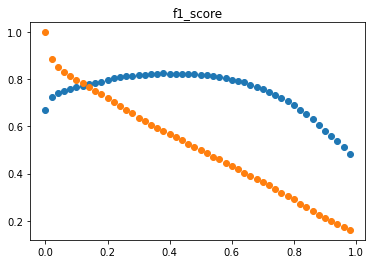

In [26]:
best_score, best_threshold = optimize_threshold(oof3, list(train_data["state"]))
print(best_score, best_threshold)

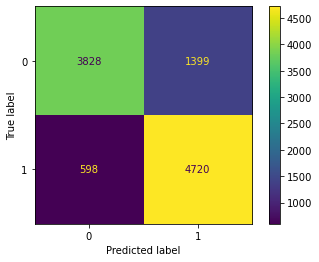

In [27]:
cm = confusion_matrix(list(train_data["state"]), np.where(oof3<best_threshold, 0, 1))
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()

In [28]:
def making_sub(preds, threshold):
    preds = np.where(preds<threshold, 0, 1)
    
    df = pd.DataFrame(columns=["id", "state"])
    df["state"] = preds
    df["id"] = range(10545, 21089)
    return df

<AxesSubplot:>

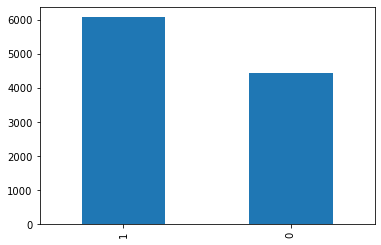

In [29]:
sub_file = making_sub(preds3, best_threshold)
sub_file.to_csv(f"./sub_files/stacking_sub_{13}.csv", index=False, header=False)
plt.figure()
sub_file["state"].value_counts().plot(kind="bar")